In [1]:
!python --version

Python 3.11.6


In [1]:
import os
import io
import pandas as pd
from google.cloud import storage
import ast
import matplotlib.pyplot as plt 
import seaborn as sns
import networkx as nx
import warnings
import dask.dataframe as dd
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

key1 = os.getenv('GCP_KEY_1')
key2 = os.getenv('GCP_KEY_2')



#### vote

##### accounts_attendance

In [2]:
accounts_attendance = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_attendance.parquet', engine='pyarrow')

In [ ]:
accounts_attendance

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453
...,...,...,...
349632,360501,[],897005
349633,360502,"[""2024-05-09""]",1407059
349634,360503,"[""2024-05-09""]",1583727
349635,360504,"[""2024-05-09""]",1392372


In [6]:
accounts_attendance.isnull().sum()

id                      0
attendance_date_list    0
user_id                 0
dtype: int64

In [7]:
accounts_attendance.duplicated().sum()

0

In [9]:
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
# 한 번도 접속하지 않은 이용자는 20945명이다.
accounts_attendance.explode('attendance_date_list').isnull().sum()

id                          0
attendance_date_list    20945
user_id                     0
dtype: int64

In [ ]:
# 출석 시간이 중복되는 이용자는 0명이다
accounts_attendance.explode('attendance_date_list').duplicated(subset=['attendance_date_list','user_id']).sum()

0

In [ ]:
attend = accounts_attendance.explode('attendance_date_list')

In [24]:
attend

,id,attendance_date_list,user_id
0,1,2023-05-27,1446852
25299,25901,2023-05-27,1490536
25298,25900,2023-05-27,942100
25297,25899,2023-05-27,902834
25296,25898,2023-05-27,1352980
...,...,...,...
90403,93546,2024-05-09,1217716
104690,108337,2024-05-09,1504940
43886,45200,2024-05-09,846346
242384,250294,2024-05-09,1276487


In [ ]:
attend = attend[attend['attendance_date_list'].isnull()==False].sort_values(by = 'attendance_date_list')

In [12]:
attend = attend.sort_values(by = 'attendance_date_list')

In [ ]:
accounts_attendance = attend.drop_duplicates(subset=['user_id'],keep='last')[['user_id','attendance_date_list']].rename(columns={'attendance_date_list':'created_at'})

##### accounts_blockrecord

In [16]:
accounts_blockrecord = pd.read_parquet('gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet', engine='pyarrow')

In [ ]:
accounts_blockrecord

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177
...,...,...,...,...,...
19477,25355,사칭 계정,2024-04-05 08:15:03,875351,879416
19478,25356,친구 사이가 어색해짐,2024-04-25 09:28:19,1444256,1292346
19479,25357,친구 사이가 어색해짐,2024-04-25 09:28:24,1379126,1292346
19480,25360,모르는 사람임,2024-05-05 11:06:31,1582869,1583612


In [27]:
accounts_blockrecord.loc[accounts_blockrecord.duplicated(subset=['block_user_id','user_id'],keep = False) == True]

,id,reason,created_at,block_user_id,user_id
8,12,기타,2023-05-05 13:04:31,885794,879662
9,13,기타,2023-05-05 13:04:42,885794,879662
10,14,그냥...,2023-05-05 13:04:52,885794,879662
11,15,기타,2023-05-05 13:04:56,885794,879662
12,16,기타,2023-05-05 13:05:01,885794,879662
...,...,...,...,...,...
19228,24886,모르는 사람임,2023-08-15 18:38:41,992181,1072478
19240,24899,친구 사이가 어색해짐,2023-08-18 12:12:28,1500131,1365572
19248,24912,모르는 사람임,2023-08-21 23:12:23,1029653,955098
19295,25105,모르는 사람임,2023-09-11 14:09:18,1019326,976341


In [4]:
accounts_blockrecord.isnull().sum()

id               0
reason           0
created_at       0
block_user_id    0
user_id          0
dtype: int64

In [18]:
accounts_blockrecord = accounts_blockrecord.sort_values(by = 'created_at')

In [19]:
accounts_blockrecord = accounts_blockrecord.drop_duplicates(subset=['user_id'],keep='last')[['user_id','created_at']]

##### accounts_failpaymenthistory

In [20]:
accounts_failpaymenthistory = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet', engine='pyarrow')

In [ ]:
accounts_failpaymenthistory

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730
...,...,...,...,...,...
158,170,heart.777,A,2023-07-28 08:31:19,1254708
159,171,None,I,2023-08-12 11:26:59,1556867
160,172,heart.777,A,2023-08-14 23:47:46,1282373
161,173,None,I,2023-09-17 09:12:53,927108


In [30]:
accounts_failpaymenthistory.isnull().sum()

id              0
productId     107
phone_type      0
created_at      0
user_id         0
dtype: int64

In [35]:
accounts_failpaymenthistory.loc[accounts_failpaymenthistory['productId'].isnull() == True,'phone_type'].unique()

array(['I'], dtype=object)

In [21]:
accounts_failpaymenthistory = accounts_failpaymenthistory.sort_values(by = 'created_at')

In [22]:
accounts_failpaymenthistory = accounts_failpaymenthistory.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_friendrequest

In [23]:
accounts_friendrequest = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_friendrequest.parquet', engine='pyarrow')

In [ ]:
accounts_friendrequest

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521
...,...,...,...,...,...,...
17147170,19692975,P,2024-05-09 07:24:50,2024-05-09 07:24:50,1583730,1583731
17147171,19692976,A,2024-05-09 07:31:41,2024-05-09 07:33:06,1583731,1583673
17147172,19692977,P,2024-05-09 08:20:44,2024-05-09 08:20:44,1299129,1575671
17147173,19692978,R,2024-05-09 09:19:40,2024-05-09 09:19:43,1304403,1392729


In [4]:
accounts_friendrequest.isnull().sum()

id                 0
status             0
created_at         0
updated_at         0
receive_user_id    0
send_user_id       0
dtype: int64

In [9]:
accounts_friendrequest.groupby(['receive_user_id'])[['send_user_id']].count().reset_index().sort_values(by='send_user_id',ascending=False)

,receive_user_id,send_user_id
59349,909685,218
14991,857348,199
64689,915445,198
10898,852224,195
220018,1083638,190
...,...,...
586160,1490579,1
482285,1372948,1
629462,1540454,1
646667,1560385,1


In [ ]:
accounts_friendrequest = accounts_friendrequest.sort_values(by = 'created_at')

In [ ]:
accounts_friendrequest = accounts_friendrequest.drop_duplicates(subset=['send_user_id'], keep='last')[['send_user_id','created_at']].rename(columns={'send_user_id': 'user_id'})

##### accounts_group

In [10]:
accounts_group = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_group.parquet', engine='pyarrow')

In [11]:
accounts_group

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [12]:
accounts_group.isnull().sum()

id           0
grade        0
class_num    0
school_id    0
dtype: int64

##### accounts_nearbyschool

In [13]:
accounts_nearbyschool = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_nearbyschool.parquet', engine='pyarrow')

In [14]:
accounts_nearbyschool

,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7
...,...,...,...,...
59495,178516,0.018277,1498,5961
59496,178517,0.018652,1474,5961
59497,178518,0.021143,1466,5961
59498,178519,0.024572,1467,5961


In [15]:
accounts_nearbyschool.isnull().sum()

id                  0
distance            0
nearby_school_id    0
school_id           0
dtype: int64

##### accounts_paymenthistory

In [24]:
accounts_paymenthistory = pd.read_parquet('gs://sprint_final_project/final_project/votes/accounts_paymenthistory.parquet', engine='pyarrow')

In [ ]:
accounts_paymenthistory

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081
...,...,...,...,...,...
95135,98074,heart.777,I,2024-05-06 14:51:27,1086654
95136,98075,heart.1000,I,2024-05-06 16:06:30,871740
95137,98076,heart.1000,I,2024-05-08 06:57:23,1166361
95138,98077,heart.1000,I,2024-05-08 14:12:45,1163480


In [18]:
accounts_paymenthistory.isnull().sum()

id            0
productId     0
phone_type    0
created_at    0
user_id       0
dtype: int64

In [3]:
payment = accounts_paymenthistory.groupby('user_id')['id'].count().reset_index().sort_values(by='id', ascending=False)

In [25]:
payment

,user_id,id
55604,1527451,60
27744,1246471,51
17651,1141603,35
23067,1204373,34
17740,1142775,30
...,...,...
22263,1196164,1
22264,1196170,1
22265,1196185,1
22266,1196197,1


In [29]:
accounts_paymenthistory['productId'].unique()

array(['heart.777', 'heart.200', 'heart.4000', 'heart.1000'], dtype=object)

In [14]:
accounts_paymenthistory['plus_point'] = accounts_paymenthistory['productId'].map(lambda x: int(x.split('.')[1]))

In [27]:
payment_plus_point = accounts_paymenthistory.groupby(['user_id'])[['plus_point']].sum().sort_values(by='plus_point', ascending=False).reset_index()

In [58]:
payment_plus_point

,user_id,plus_point
0,1141603,75977
1,1167602,56777
2,1216899,49977
3,1111139,44777
4,1246471,42977
...,...,...
59187,1471470,200
59188,1488005,200
59189,1417284,200
59190,1549489,200


In [28]:
accounts_paymenthistory.sort_values(by='created_at')

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081
...,...,...,...,...,...
95135,98074,heart.777,I,2024-05-06 14:51:27,1086654
95136,98075,heart.1000,I,2024-05-06 16:06:30,871740
95137,98076,heart.1000,I,2024-05-08 06:57:23,1166361
95138,98077,heart.1000,I,2024-05-08 14:12:45,1163480


In [29]:
accounts_paymenthistory = accounts_paymenthistory.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_user_contacts

In [39]:
accounts_user_contacts = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_user_contacts.parquet', engine='pyarrow')

In [40]:
accounts_user_contacts

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476
...,...,...,...,...
5058,12981327,7,[],1480714
5059,13391623,1,[],1506575
5060,14465598,0,[],1577436
5061,14579987,0,[],1582145


In [4]:
accounts_user_contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   5063 non-null   int64 
 1   contacts_count       5063 non-null   int64 
 2   invite_user_id_list  5063 non-null   object
 3   user_id              5063 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 158.3+ KB


In [5]:
accounts_user_contacts['invite_user_id_list'] = accounts_user_contacts['invite_user_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [9]:
accounts_user_contacts.explode('invite_user_id_list').sort_values(by='contacts_count',ascending=False)

,id,contacts_count,invite_user_id_list,user_id
35,36063,114,NaN,873573
380,141577,107,871350,877693
1152,675242,99,NaN,947480
1303,775480,92,1180993,1266116
1303,775480,92,1171380,1266116
...,...,...,...,...
2504,1541875,1,NaN,1028993
2525,1573304,1,NaN,880171
5060,14465598,0,NaN,1577436
5061,14579987,0,NaN,1582145


In [ ]:
accounts_user_contacts.explode('invite_user_id_list').isnull().sum()

id                        0
contacts_count            0
invite_user_id_list    3905
user_id                   0
dtype: int64

##### accounts_pointhistory

In [23]:
accounts_pointhistory = pd.read_parquet('gs://sprint_final_project/final_project/votes/accounts_pointhistory.parquet', engine='pyarrow')

In [ ]:
accounts_pointhistory

,id,delta_point,created_at,user_id,user_question_record_id
0,790629,9,2023-04-28 12:27:49,849436,771777.0
1,790652,9,2023-04-28 12:28:02,849436,771800.0
2,790664,5,2023-04-28 12:28:09,849436,771812.0
3,790680,13,2023-04-28 12:28:16,849436,771828.0
4,790703,5,2023-04-28 12:28:26,849436,771851.0
...,...,...,...,...,...
2338913,340672371,14,2024-05-08 01:35:02,855509,161666462.0
2338914,340672372,11,2024-05-08 01:36:00,855525,161666463.0
2338915,340672373,11,2024-05-08 01:36:00,855526,161666463.0
2338916,340672374,12,2024-05-08 01:36:18,855525,161666464.0


In [13]:
accounts_pointhistory.isnull().sum()

id                            0
delta_point                   0
created_at                    0
user_id                       0
user_question_record_id    2992
dtype: int64

In [7]:
accounts_pointhistory.describe()

,id,delta_point,created_at,user_id,user_question_record_id
count,2.338918e+06,2.338918e+06,2338918,2.338918e+06,2.335926e+06
mean,1.265364e+08,8.610862e-01,2023-05-18 03:06:43.825683968,1.111554e+06,6.141803e+07
min,7.906290e+05,-1.000000e+03,2023-04-28 12:27:49,8.380230e+05,7.717770e+05
25%,4.112505e+07,7.000000e+00,2023-05-11 04:37:02,8.861890e+05,2.088561e+07
50%,1.123971e+08,1.000000e+01,2023-05-16 07:29:11,1.126012e+06,5.540614e+07
75%,1.982051e+08,1.300000e+01,2023-05-22 13:47:48.750000128,1.260221e+06,9.555855e+07
max,3.406724e+08,1.000000e+03,2024-05-08 01:36:18,1.583358e+06,1.616665e+08
std,9.610992e+07,5.885849e+01,NaN,2.024429e+05,4.531970e+07


In [24]:
accounts_pointhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[ns]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 89.2 MB


In [28]:
accounts_pointhistory['delta_point'].unique()

array([    9,     5,    13,    10,    12,    15,    14,     8,     6,
          11,     7,  -300,   -10,  -200,  -500, -1000,   200,   500,
        1000,   300,   210,   240,   220,   230,   250,   777,   260,
         270,   280,   100,   -30,    50,    60,    70,    80,    90,
         110,   120,   130,   140,   150,   160,   170,   180])

In [ ]:
payment = [200,777,1000,4000]

In [26]:
accounts_pointhistory.groupby(['user_id'])[['delta_point']].sum().sort_values(by='delta_point', ascending=False).reset_index()

,user_id,delta_point
0,849103,32378
1,952220,16967
2,1058255,15696
3,896512,14834
4,1370056,14608
...,...,...
5032,1045301,-8897
5033,1152814,-9180
5034,1217035,-10003
5035,1185764,-11322


In [7]:
# 이벤트로 얻은 포인트 기록이 포인트 history와 매칭이 되는지 확인
event_hist = pd.merge(accounts_pointhistory,event_receipts, how='inner', on =['user_id','created_at'])

In [8]:
event_hist[event_hist['id_y'].isnull() == False]

,id_x,delta_point,created_at,user_id,user_question_record_id,id_y,event_id,plus_point
0,334362280,500,2023-07-11 09:24:04,873726,NaN,86,1,500
1,335273007,500,2023-07-15 14:07:55,1193797,NaN,132,1,500
2,336288033,500,2023-07-21 14:09:08,1112856,NaN,183,1,500
3,337203071,500,2023-07-29 09:37:33,1335899,NaN,238,1,500
4,338468674,1000,2023-08-16 16:35:52,1235550,NaN,287,2,1000
5,338515747,1000,2023-08-18 04:26:33,1577440,NaN,294,2,1000


In [9]:
# 결제를 통해 얻은 포인트 기록과 포인트 history가 매칭이 되는지 확인 
payment_hist = pd.merge(accounts_pointhistory,accounts_paymenthistory,how='inner',on=['user_id','created_at'])

In [10]:
payment_hist[(payment_hist['id_y'].isnull()==False)]

,id_x,delta_point,created_at,user_id,user_question_record_id,id_y,productId,phone_type
0,334354539,1000,2023-07-11 09:16:21,871350,NaN,93031,heart.1000,I
1,334356885,777,2023-07-11 09:18:41,883793,NaN,93039,heart.777,I
2,334362089,777,2023-07-11 09:23:49,858375,NaN,93058,heart.777,I
3,334363526,777,2023-07-11 09:26:09,876123,NaN,93067,heart.777,I
4,334375704,777,2023-07-11 09:58:36,870172,NaN,93090,heart.777,I
...,...,...,...,...,...,...,...,...
56,340463999,200,2024-01-06 14:23:39,875314,NaN,97668,heart.200,I
57,340599301,777,2024-02-27 14:41:47,1318890,NaN,97876,heart.777,A
58,340599301,777,2024-02-27 14:41:47,1318890,NaN,97877,heart.777,A
59,340599302,777,2024-02-27 14:41:47,1318890,NaN,97876,heart.777,A


In [57]:
payment_hist[(payment_hist['id_y'].isnull()==False) & (payment_hist['delta_point'] == 200)].shape

(29, 9)

In [56]:
payment_hist[(payment_hist['id_y'].isnull()==False) & (payment_hist['delta_point'] == 777)].shape

(25, 9)

결제를 통해 얻은 포인트, event 참여로 얻은 포인트가 pointhistory 테이블에 제대로 저장되어 있지 않음 그래서 정확히 뭐가 이벤트고 뭐가 결제인지 구분하기가 쉽지 않음    
이대로 봐도 상관없다면 뭐 그냥 하겠지만 이대로 하면 숫자에 왜곡되는 문제가 발생할 수 있음

In [47]:
accounts_pointhistory.groupby(['delta_point'])[['id']].count()

,id
delta_point,
-1000,1422
-500,6147
-300,40266
-200,20781
-30,1
-10,39966
5,203173
6,203479
7,202967


In [32]:
accounts_pointhistory = accounts_pointhistory.sort_values(by='created_at')

In [33]:
accounts_pointhistory = accounts_pointhistory.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_school

In [5]:
accounts_school = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_school.parquet', engine='pyarrow')

In [6]:
accounts_school

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M
...,...,...,...,...
5946,5960,경상남도 양산시,166,H
5947,5961,인천광역시 서구,77,M
5948,5963,경북 김천시,17,H
5949,5964,-,1,H


In [7]:
accounts_school.isnull().sum()

id               0
address          0
student_count    0
school_type      0
dtype: int64

##### accounts_timelinereport

In [36]:
accounts_timelinereport = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_timelinereport.parquet', engine='pyarrow')

In [ ]:
accounts_timelinereport

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049
...,...,...,...,...,...,...
203,21857,선정적이거나 폭력적인 내용,2023-05-29 15:42:50,1479859,1402487,131364422
204,22634,허위 사실 언급,2023-05-31 10:33:00,1551005,1161757,135982670
205,22635,허위 사실 언급,2023-05-31 10:33:06,1551005,1161757,134909577
206,23022,선정적이거나 폭력적인 내용,2023-06-01 16:02:33,1479859,1498172,139837310


In [10]:
accounts_timelinereport.isnull().sum()

id                         0
reason                     0
created_at                 0
reported_user_id           0
user_id                    0
user_question_record_id    0
dtype: int64

In [37]:
accounts_timelinereport= accounts_timelinereport.sort_values(by='created_at')

In [38]:
accounts_timelinereport = accounts_timelinereport.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_user

In [2]:
accounts_user = pd.read_parquet('gs://sprint_final_project/final_project/processed/processed_accounts_user_processed.parquet', engine='pyarrow', storage_options={'token': key2})

In [13]:
accounts_user

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677080,1583729,0,0,M,300,[],1,2024-05-08 21:54:33.621408,[],[],N,0,0,0,0,32442.0
677081,1583730,0,0,M,420,"[1109507, 1110921, 1111072, 1110054, 1108393, ...",0,2024-05-09 07:08:11.001817,[],[],N,0,1,0,0,43949.0
677082,1583731,0,0,M,300,"[1583732, 1583673]",1,2024-05-09 07:22:19.186439,[],[],N,0,1,0,0,18640.0
677083,1583732,0,0,F,300,"[1583673, 1583730, 1583731]",1,2024-05-09 07:22:38.387553,[],[],N,0,0,0,0,18640.0


In [ ]:
accounts_user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id,friend_count,is_point_specialist,is_friend_specialist,is_specialist,specialist_type
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN,6,False,False,False,normal
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0,43,False,False,False,normal
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0,51,False,False,False,normal
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0,57,False,False,False,normal
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0,18,False,False,False,normal


In [9]:
accounts_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    677085 non-null  int64         
 1   is_superuser          677085 non-null  int64         
 2   is_staff              677085 non-null  int64         
 3   gender                677083 non-null  object        
 4   point                 677085 non-null  int64         
 5   friend_id_list        677085 non-null  object        
 6   is_push_on            677085 non-null  int64         
 7   created_at            677085 non-null  datetime64[ns]
 8   block_user_id_list    677085 non-null  object        
 9   hide_user_id_list     677085 non-null  object        
 10  ban_status            677085 non-null  object        
 11  report_count          677085 non-null  int64         
 12  alarm_count           677085 non-null  int64         
 13 

In [15]:
accounts_user.isnull().sum()

id                    0
is_superuser          0
is_staff              0
gender                2
point                 0
friend_id_list        0
is_push_on            0
created_at            0
block_user_id_list    0
hide_user_id_list     0
ban_status            0
report_count          0
alarm_count           0
pending_chat          0
pending_votes         0
group_id              3
dtype: int64

In [3]:
accounts_user['friend_id_list'] = accounts_user['friend_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
accounts_user['block_user_id_list'] = accounts_user['block_user_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
accounts_user['hide_user_id_list'] = accounts_user['hide_user_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [4]:
explode_friend = accounts_user.explode('friend_id_list')

In [7]:
explode_friend.groupby(['id']).value_counts().sort_values().reset_index()

: 

: 

: 

In [13]:
explode_friend.info()

<class 'pandas.core.frame.DataFrame'>
Index: 677085 entries, 0 to 677084
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  677085 non-null  int64         
 1   is_superuser        677085 non-null  int64         
 2   is_staff            677085 non-null  int64         
 3   gender              677083 non-null  object        
 4   point               677085 non-null  int64         
 5   friend_id_list      677085 non-null  object        
 6   is_push_on          677085 non-null  int64         
 7   created_at          677085 non-null  datetime64[ns]
 8   block_user_id_list  677085 non-null  object        
 9   hide_user_id_list   677085 non-null  object        
 10  ban_status          677085 non-null  object        
 11  report_count        677085 non-null  int64         
 12  alarm_count         677085 non-null  int64         
 13  pending_chat        677085 non-nul

In [7]:
accounts_user.explode('block_user_id_list').isnull().sum()

id                         0
is_superuser               0
is_staff                   0
gender                     2
point                      0
friend_id_list             0
is_push_on                 0
created_at                 0
block_user_id_list    664042
hide_user_id_list          0
ban_status                 0
report_count               0
alarm_count                0
pending_chat               0
pending_votes              0
group_id                   3
dtype: int64

In [8]:
accounts_user.explode('hide_user_id_list').isnull().sum()

id                         0
is_superuser               0
is_staff                   0
gender                     2
point                      0
friend_id_list             0
is_push_on                 0
created_at                 0
block_user_id_list         0
hide_user_id_list     598352
ban_status                 0
report_count               0
alarm_count                0
pending_chat               0
pending_votes              0
group_id                   3
dtype: int64

In [5]:
accounts_user.describe()

,id,is_superuser,is_staff,point,is_push_on,created_at,report_count,alarm_count,pending_chat,pending_votes,group_id
count,6.770850e+05,677085.000000,677085.000000,6.770850e+05,677085.000000,677085,677085.000000,677085.000000,677085.000000,677085.000000,677082.000000
mean,1.212969e+06,0.000003,0.000004,3.039145e+03,0.843098,2023-05-15 22:46:01.709213440,0.037291,0.946646,0.098469,84.630518,37022.980168
min,8.319560e+05,0.000000,0.000000,0.000000e+00,0.000000,2023-03-29 03:44:14.047130,0.000000,0.000000,-1.000000,0.000000,1.000000
25%,1.028075e+06,0.000000,0.000000,4.000000e+02,1.000000,2023-05-09 01:35:23.126586880,0.000000,0.000000,0.000000,2.000000,18488.000000
50%,1.211729e+06,0.000000,0.000000,9.650000e+02,1.000000,2023-05-13 10:50:57.476214016,0.000000,1.000000,0.000000,29.000000,35614.000000
75%,1.397906e+06,0.000000,0.000000,2.183000e+03,1.000000,2023-05-20 07:49:47.800349952,0.000000,1.000000,0.000000,122.000000,54534.000000
max,1.583733e+06,1.000000,1.000000,8.850000e+08,1.000000,2024-05-09 08:31:17.710824,253.000000,40878.000000,5712.000000,3352.000000,84546.000000
std,2.138971e+05,0.001719,0.002105,1.076020e+06,0.363709,NaN,0.588105,56.114858,11.087769,123.262688,21997.765398


In [10]:
accounts_user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,...,report_count,alarm_count,pending_chat,pending_votes,group_id,friend_count,is_point_specialist,is_friend_specialist,is_specialist,specialist_type
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],...,0,0,0,0,NaN,6,False,False,False,normal
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],...,253,40878,5499,110,12.0,43,False,False,False,normal
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],...,0,37,0,47,1.0,51,False,False,False,normal
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],...,0,19,0,21,1.0,57,False,False,False,normal
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],...,0,29,0,15,12.0,18,False,False,False,normal


In [3]:
accounts_user['period_d'] = accounts_user['created_at'].dt.to_period('D').astype(str)

In [4]:
accounts_day = accounts_user.groupby(['period_d'])[['id']].count().reset_index()

In [5]:
xticks = accounts_user['created_at'].dt.to_period('M').drop_duplicates().dt.to_timestamp()

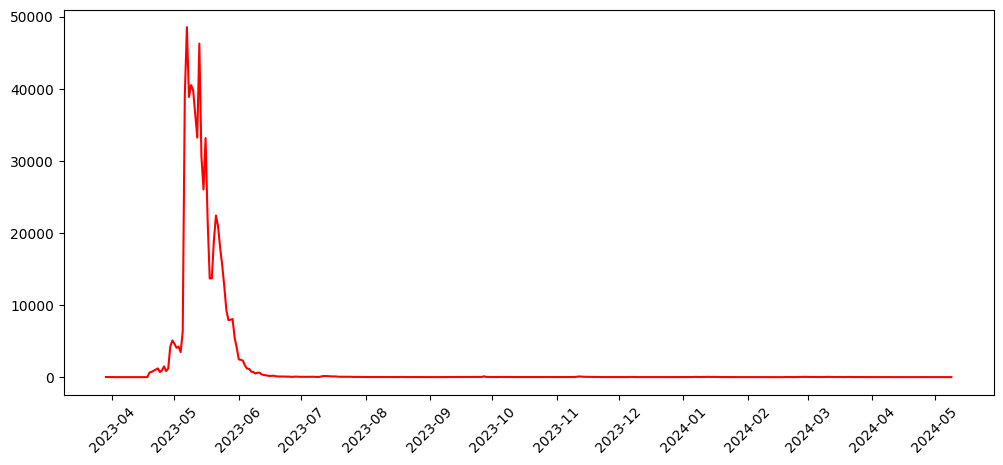

In [6]:
# Convert period_d to datetime for plotting
period_d_dt = pd.to_datetime(accounts_day['period_d'])

plt.figure(figsize=(12,5))
plt.plot(period_d_dt, accounts_day['id'], color='red')

# Set xticks at the start of each month
month_starts = period_d_dt[period_d_dt.dt.is_month_start].drop_duplicates()
plt.xticks(ticks=month_starts, labels=month_starts.dt.strftime('%Y-%m'), rotation=45)

plt.show()

In [ ]:
# Convert period_d to datetime for plotting
period_d_dt = pd.to_datetime(accounts_day['period_d'])

plt.figure(figsize=(12,5))
plt.plot(period_d_dt, accounts_day['id'], color='red')

# Set xticks at the start of each month
month_starts = period_d_dt[period_d_dt.dt.is_month_start].drop_duplicates()
plt.xticks(ticks=month_starts, labels=month_starts.dt.strftime('%Y-%m'), rotation=45)

plt.show()

SyntaxError: positional argument follows keyword argument (4129910871.py, line 5)

In [7]:
accounts_user['period_m'] = accounts_user['created_at'].dt.to_period('M')

In [12]:
month = accounts_user.groupby(['period_m'])[['id']].count().reset_index()

In [13]:
month['total'] = accounts_user['id'].count()

In [15]:
month['ratio'] = month['id'] / month['total']

In [ ]:
month # 2023년 5월에 93.85%가 가입하였습니다

,period_m,id,total,ratio
0,2023-03,33,677085,0.000049
1,2023-04,19060,677085,0.028150
2,2023-05,635505,677085,0.938590
3,2023-06,16737,677085,0.024719
4,2023-07,1849,677085,0.002731
5,2023-08,524,677085,0.000774
6,2023-09,605,677085,0.000894
7,2023-10,409,677085,0.000604
8,2023-11,731,677085,0.001080
9,2023-12,231,677085,0.000341


<Axes: xlabel='period_m'>

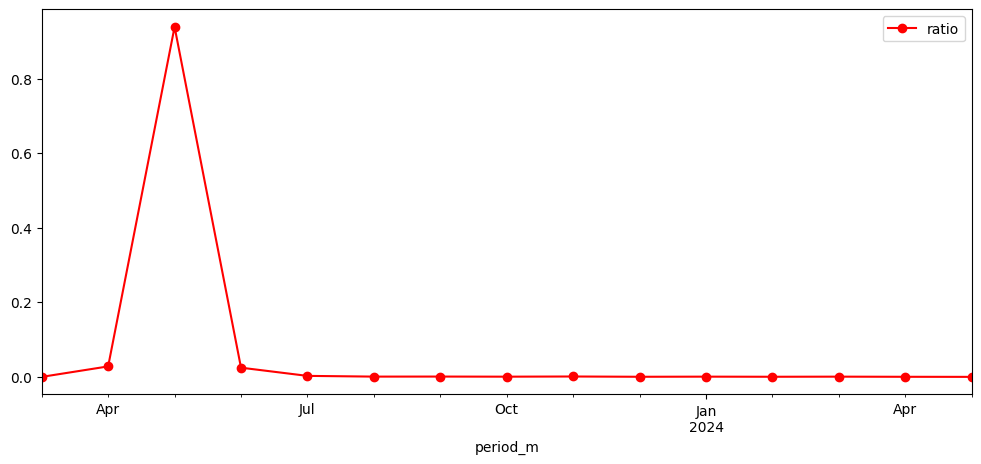

In [26]:
month.plot( x='period_m', y='ratio',figsize=(12, 5),marker = 'o', color='red')

In [80]:
user = accounts_user[['id','created_at']]

##### accounts_userquestionrecord

In [39]:
accounts_userquestionrecord = pd.read_parquet('gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet', engine='pyarrow')

In [ ]:
accounts_userquestionrecord

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1217553,161666166,C,2024-05-07 11:29:07,945560,2614,1001607,190864020,1,N,2024-05-07 11:29:07,0,0
1217554,161666461,C,2024-05-08 01:34:56,850774,1679,855525,200139931,0,N,2024-05-08 01:34:56,0,0
1217555,161666462,C,2024-05-08 01:35:02,855509,2605,855525,200139932,0,N,2024-05-08 01:35:02,0,0
1217556,161666463,C,2024-05-08 01:36:00,855526,3801,855525,200139933,0,N,2024-05-08 01:36:00,0,0


In [4]:
accounts_userquestionrecord.isnull().sum()

id                   0
status               0
created_at           0
chosen_user_id       0
question_id          0
user_id              0
question_piece_id    0
has_read             0
answer_status        0
answer_updated_at    0
report_count         0
opened_times         0
dtype: int64

In [ ]:
accounts_userquestionrecord.loc[(accounts_userquestionrecord['has_read']==1) & (accounts_userquestionrecord['answer_status']!='N')]

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
345,778243,C,2023-04-28 13:14:34,849548,200,850006,1009125,1,P,2023-05-06 16:49:33,0,0
1848,802848,C,2023-04-28 16:05:09,849548,166,850610,1043525,1,P,2023-05-06 16:49:21,0,0
3097,815819,I,2023-04-28 23:31:19,849515,320,847375,1034711,1,P,2023-05-06 10:09:27,0,1
10109,945319,I,2023-04-29 13:22:05,849995,132,851717,1213085,1,P,2023-05-06 10:31:30,0,3
11512,989867,C,2023-04-29 15:20:38,849498,315,850180,1259999,1,A,2023-05-12 15:33:47,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1182397,150784898,C,2023-06-07 15:41:57,887991,2356,883374,191553936,1,A,2023-06-07 15:42:58,0,0
1182400,150785481,C,2023-06-07 15:42:37,887991,3822,883374,191553939,1,A,2023-06-07 15:43:09,0,0
1182563,150825226,C,2023-06-07 16:41:50,869580,2285,877117,192477279,1,A,2023-06-07 16:43:00,0,0
1182570,150825637,I,2023-06-07 16:42:40,887714,2357,869580,190234929,1,A,2023-06-07 17:40:52,0,1


In [40]:
accounts_userquestionrecord = accounts_userquestionrecord.sort_values(by='answer_updated_at')

In [41]:
accounts_userquestionrecord = accounts_userquestionrecord.drop_duplicates(subset=['user_id'], keep='last')[['user_id','answer_updated_at']].rename(columns={'answer_updated_at': 'created_at'})

##### accounts_userwithdraw

In [5]:
accounts_userwithdraw = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_userwithdraw.parquet', engine='pyarrow')

In [6]:
accounts_userwithdraw

,id,reason,created_at
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19
...,...,...,...
70759,70889,기타 이유,2024-05-08 14:24:16
70760,70890,함께 할 친구가 없어서,2024-05-08 15:20:06
70761,70891,재밌는 질문이 없어서,2024-05-08 15:46:36
70762,70892,기타 이유,2024-05-09 08:29:09


In [7]:
accounts_userwithdraw.isnull().sum()

id            0
reason        0
created_at    0
dtype: int64

##### event_receipts

In [42]:
event_receipts = pd.read_parquet('gs://sprintda05_final_project/votes/event_receipts.parquet', engine='pyarrow')

In [ ]:
event_receipts.sort_values(by='created_at', ascending=False)

,id,created_at,event_id,user_id,plus_point
308,321,2023-11-21 12:03:02,3,1568685,500
307,320,2023-11-17 06:17:59,3,1296978,500
306,319,2023-11-17 06:17:25,3,1188104,500
305,318,2023-11-15 05:09:02,3,932419,500
304,317,2023-11-14 11:17:29,3,918053,500
...,...,...,...,...,...
4,6,2023-06-22 13:40:38,1,1168260,500
3,5,2023-06-22 13:03:06,1,974697,500
2,4,2023-06-22 10:32:15,1,904872,500
1,3,2023-06-22 09:38:53,1,928351,500


In [10]:
event_receipts.isnull().sum()

id            0
created_at    0
event_id      0
user_id       0
plus_point    0
dtype: int64

In [19]:
event_receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          309 non-null    int64         
 1   created_at  309 non-null    datetime64[ns]
 2   event_id    309 non-null    int64         
 3   user_id     309 non-null    int64         
 4   plus_point  309 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 12.2 KB


In [30]:
event_receipts['plus_point'].unique()

array([ 500, 1000])

In [ ]:
event_plus_point = event_receipts.groupby(['user_id'])[['plus_point']].sum().sort_values(by='plus_point', ascending=False).reset_index()

,user_id,plus_point
0,837836,1000
1,1541150,1000
2,1115176,1000
3,1107696,1000
4,1512731,1000
...,...,...
303,1062030,500
304,1061829,500
305,1056997,500
306,1056664,500


In [44]:
event_receipts = event_receipts.sort_values(by='created_at')

In [45]:
event_receipts = event_receipts.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### events

In [11]:
events = pd.read_parquet('gs://sprintda05_final_project/votes/events.parquet', engine='pyarrow')

In [12]:
events

,id,title,plus_point,event_type,is_expired,created_at
0,1,코드잇 은행 가입 이벤트,500,FCFS,1,2023-06-20 11:56:38
1,2,코드잇 멤버십 가입 이벤트,1000,FCFS,1,2023-08-08 07:43:45
2,3,예고 영상 기대평 이벤트,500,FCFS,1,2023-09-24 17:05:59


In [13]:
events.isnull().sum()

id            0
title         0
plus_point    0
event_type    0
is_expired    0
created_at    0
dtype: int64

##### polls_question

In [46]:
polls_question = pd.read_parquet('gs://sprintda05_final_project/votes/polls_question.parquet', engine='pyarrow')

In [52]:
polls_question

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55
...,...,...,...
5020,5129,나에게 가장 중요한 사람은?,2023-06-06 06:15:52
5021,5130,오목을 제일 잘 할 것 같은 사람은?,2023-06-06 06:15:52
5022,5131,가방에서 쓰레기가 안 나올 것 같은 사람은?,2023-06-06 06:15:52
5023,5132,아무리 많은 숙제도 30분만에 다 끝내버릴 수 있을 것 같은 친구는?,2023-06-06 06:15:52


In [16]:
polls_question.isnull().sum()

id               0
question_text    0
created_at       0
dtype: int64

In [30]:
hour = polls_question['created_at'].dt.hour

In [35]:
polls_question.loc[polls_question['created_at'].dt.hour == 3]

,id,question_text,created_at
462,561,얘랑 친해지면 세상 모두랑 친해질 수 있을 것 같았던 사람은?,2023-05-04 03:36:37


In [38]:
hour.value_counts()

created_at
6     1966
8     1523
14     732
13     250
5      235
15     164
11     154
3        1
Name: count, dtype: int64

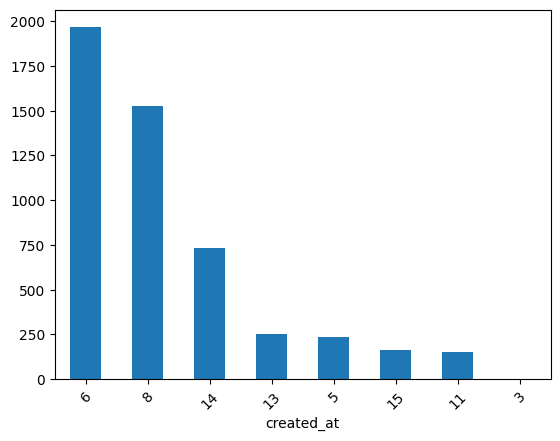

In [ ]:
hour.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

In [60]:
polls_question.loc[polls_question['id'].isin([170,169,186,211,290])]

,id,question_text,created_at
70,169,축제에서 공연을 제일 잘 할거 같은 사람은?,2023-03-31 15:23:29
71,170,처음 보는 사람과 가장 빨리 친해질 것 같은 사람은?,2023-03-31 15:23:30
87,186,vote,2023-04-01 11:09:15
112,211,앞으로의 인생을 가장 재미있게 살것 같은 사람은?,2023-04-01 11:09:20
191,290,모든 사람과 잘 지낼 것 같은 사람은?,2023-04-01 11:09:35


In [30]:
polls_question.loc[polls_question['id']==111]

,id,question_text,created_at
12,111,마스크가 잘 어울리는 사람은?,2023-03-31 15:22:59


In [26]:
df = pd.merge(polls_question,report,how='left',on='id')

In [36]:
df1 = df[df['question_text'].str.contains('vote',case=False)]

In [74]:
df2 = pd.merge(df1,piece_count,how='left',on='id') 
df2

,id,question_text,created_at,count,count1
0,186,vote,2023-04-01 11:09:15,45.0,1991.0
1,483,vote,2023-05-02 05:33:11,73.0,1615.0
2,639,vote,2023-05-11 15:52:44,16.0,580.0
3,696,vote,2023-05-15 13:58:24,34.0,411.0
4,712,vote,2023-05-15 13:58:30,15.0,381.0
5,725,vote,2023-05-15 13:58:35,7.0,392.0
6,736,vote,2023-05-15 13:58:40,32.0,358.0
7,807,vote,2023-05-15 13:59:11,34.0,357.0
8,881,vote,2023-05-15 13:59:44,39.0,365.0
9,940,vote,2023-05-15 14:00:10,20.0,333.0


In [81]:
vote_text = df2['id'].to_list()

In [28]:
polls_question[polls_question['question_text'].str.contains('vote', case=False)].head(5)

,id,question_text,created_at
87,186,vote,2023-04-01 11:09:15
384,483,vote,2023-05-02 05:33:11
540,639,vote,2023-05-11 15:52:44
587,696,vote,2023-05-15 13:58:24
603,712,vote,2023-05-15 13:58:30


##### polls_questionpiece

In [47]:
polls_questionpiece = pd.read_parquet('gs://sprintda05_final_project/votes/polls_questionpiece.parquet', engine='pyarrow')

In [15]:
polls_questionpiece

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0
...,...,...,...,...,...
1265471,208385226,0,2024-05-07 11:32:30,960,0
1265472,208385227,0,2024-05-07 11:32:30,1402,0
1265473,208385228,0,2024-05-07 11:32:30,1676,0
1265474,208385229,0,2024-05-07 11:32:30,3115,0


In [13]:
piece_count = polls_questionpiece.groupby(['question_id'])[['id']].count().sort_values(by='id',ascending=False).reset_index().rename(columns={'id' : 'count1','question_id': 'id'})

In [ ]:
piece_count

,id,count1
0,170,2030
1,290,2021
2,169,2017
3,211,2009
4,186,1991
...,...,...
4939,4926,1
4940,4556,1
4941,4551,1
4942,4931,1


In [51]:
piece_count.describe()

,id,count1
count,4944.000000,4944.000000
mean,2587.901699,255.961974
std,1441.905349,478.950128
min,99.000000,1.000000
25%,1344.750000,14.000000
50%,2580.500000,33.000000
75%,3816.250000,355.000000
max,5133.000000,2030.000000


In [87]:
vote_questionpiece = polls_questionpiece.loc[polls_questionpiece['question_id'].isin(vote_text),'id'].to_list()

In [12]:
questionpiece_voted = polls_questionpiece.groupby(['question_id'])[['is_voted']].sum().sort_values(by='is_voted',ascending=False).reset_index().rename(columns={'is_voted': 'count2','question_id': 'id'})

In [17]:
piece_voted_count = pd.merge(piece_count,questionpiece_voted,how='left',on='id').sort_values(by='count1',ascending=False)

In [19]:
piece_voted_count['ratio'] = piece_voted_count['count2'] / piece_voted_count['count1']

In [25]:
piece_voted_count.describe()

,id,count1,count2,ratio
count,4944.000000,4944.000000,4944.000000,4944.000000
mean,2587.901699,255.961974,246.498180,0.801884
std,1441.905349,478.950128,470.798358,0.208031
min,99.000000,1.000000,0.000000,0.000000
25%,1344.750000,14.000000,10.000000,0.729730
50%,2580.500000,33.000000,27.000000,0.837838
75%,3816.250000,355.000000,340.000000,0.963418
max,5133.000000,2030.000000,1998.000000,1.000000


##### polls_questionreport

In [48]:
polls_questionreport = pd.read_parquet('gs://sprintda05_final_project/votes/polls_questionreport.parquet', engine='pyarrow')

In [ ]:
polls_questionreport

,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922
...,...,...,...,...,...
51419,55763,그냥 싫어,2024-04-19 12:49:57,350,1542237
51420,55764,그냥 싫어,2024-04-19 12:50:02,3541,1542237
51421,55765,그냥 싫어,2024-04-28 06:35:38,392,984791
51422,55766,그냥 싫어,2024-04-30 04:48:25,4979,1583634


In [65]:
polls_questionreport.groupby(['question_id'])[['id']].count().reset_index().rename(columns={'id': 'count'}).sort_values(by='count', ascending=False)

,question_id,count
12,111,988
311,410,803
299,398,660
325,424,533
206,305,493
...,...,...
2439,2980,1
1801,2019,1
2441,2983,1
2443,2986,1


In [ ]:
polls_questionreport.loc[polls_questionreport['question_id']==111]

In [60]:
report = polls_questionreport.groupby(['question_id'])[['id']].count().reset_index().rename(columns={'id' : 'count', 'question_id': 'id'}).sort_values(by='count',ascending=False)

In [64]:
report.head(5) 

,id,count
12,111,988
311,410,803
299,398,660
325,424,533
206,305,493


In [ ]:
report.describe()

,id,count
count,3135.000000,3135.000000
mean,1921.597448,16.403190
std,1231.248878,38.455215
min,99.000000,1.000000
25%,892.500000,1.000000
50%,1682.000000,4.000000
75%,2849.000000,19.000000
max,5110.000000,988.000000


In [49]:
polls_questionreport = polls_questionreport.sort_values(by='created_at')

In [50]:
polls_questionreport = polls_questionreport.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### polls_questionset

In [15]:
polls_questionset = pd.read_parquet('gs://sprint_final_project/final_project/votes/polls_questionset.parquet', engine='pyarrow')

In [68]:
polls_questionset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158384 entries, 0 to 158383
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      158384 non-null  int64         
 1   question_piece_id_list  158384 non-null  object        
 2   opening_time            158384 non-null  datetime64[ns]
 3   status                  158384 non-null  object        
 4   created_at              158384 non-null  datetime64[ns]
 5   user_id                 158384 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 7.3+ MB


In [21]:
polls_questionset

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477
...,...,...,...,...,...,...
158379,20838253,"[208383291, 208383292, 208383293, 208383294, 2...",2024-05-05 14:46:27,C,2024-05-05 14:06:27,1251933
158380,20838344,"[208384201, 208384202, 208384203, 208384204, 2...",2024-05-06 11:38:20,C,2024-05-06 10:58:20,876072
158381,20838419,"[208384951, 208384952, 208384953, 208384954, 2...",2024-05-07 00:55:00,C,2024-05-07 00:15:00,1208878
158382,20838445,"[208385211, 208385212, 208385213, 208385214, 2...",2024-05-07 12:09:08,C,2024-05-07 11:29:08,1001607


In [17]:
polls_questionset['question_piece_id_list'] =  polls_questionset['question_piece_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [18]:
explode_questionset = polls_questionset.explode('question_piece_id_list')

In [19]:
polls_questionset  = polls_questionset.explode('question_piece_id_list')

In [58]:
explode_questionset

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,998458,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
0,99817,998459,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
0,99817,998460,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
0,99817,998461,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
0,99817,998462,2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
...,...,...,...,...,...,...
158383,20838446,208385226,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560
158383,20838446,208385227,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560
158383,20838446,208385228,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560
158383,20838446,208385229,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560


In [88]:
# text가 vote인 질문을 사용한 유저
explode_questionset.loc[explode_questionset['question_piece_id_list'].isin(vote_questionpiece)]

,id,question_piece_id_list,opening_time,status,created_at,user_id
11,99877,999061,2023-04-28 12:30:30,F,2023-04-28 12:30:30,849452
47,100144,1001728,2023-04-28 13:27:10,F,2023-04-28 12:37:10,849446
82,100659,1006883,2023-04-28 13:49:51,F,2023-04-28 12:59:52,849464
102,100956,1009852,2023-04-28 14:05:03,F,2023-04-28 13:15:03,850006
179,101876,1019049,2023-04-28 13:57:38,F,2023-04-28 13:57:38,849535
...,...,...,...,...,...,...
158367,20834940,208350163,2024-03-17 09:05:21,O,2024-03-17 08:25:21,1165963
158368,20835030,208351069,2024-03-18 15:35:54,C,2024-03-18 14:55:54,1260879
158375,20836712,208367887,2024-04-18 03:03:30,O,2024-04-18 02:23:30,1087583
158379,20838253,208383297,2024-05-05 14:46:27,C,2024-05-05 14:06:27,1251933


In [20]:
questionset = polls_questionset.groupby(['user_id'])[['id']].count().sort_values(by='id', ascending=False).reset_index()
questionset

,user_id,id
0,952220,3700
1,849103,2860
2,1184703,2150
3,1162477,2030
4,1213990,2020
...,...,...
4967,1500850,10
4968,899404,10
4969,872546,10
4970,872930,10


In [21]:
conversion = pd.merge(payment,questionset,how='left',on='user_id')
conversion

NameError: name 'payment' is not defined

In [25]:
all_users = set(accounts_user['id'].unique())
payment_users = set(accounts_paymenthistory['user_id'].unique())
questionset_users = set(polls_questionset['user_id'].unique())

In [26]:
payment_in_users = payment_users.intersection(all_users)
questionset_in_users = questionset_users.intersection(all_users)
both_users = payment_users.intersection(questionset_users)

In [16]:
print(len(payment_in_users),len(questionset_in_users),len(both_users))

59192 4972 410


In [27]:
data = {'결제자' : len(payment_in_users), 
       '질문세트 작성자' : len(questionset_in_users), 
       '둘 다 작성한 유저' : len(both_users)}

In [28]:
print("🔍 사용자 ID 기반 정확한 전환율 분석")
print("=" * 50)

print("📊 **Step 1: 각 데이터셋의 사용자 ID 확인**")

# 각 데이터셋의 사용자 ID 타입과 분포 확인
print(f"• df_user['id'] 타입: {accounts_user['id'].dtype}")
print(f"• df_payment['user_id'] 타입: {accounts_paymenthistory['user_id'].dtype}")  
print(f"• df_questionset['user_id'] 타입: {polls_questionset['user_id'].dtype}")

print(f"\n• df_user ID 범위: {accounts_user['id'].min()} ~ {accounts_user['id'].max()}")
print(f"• df_payment user_id 범위: {accounts_paymenthistory['user_id'].min()} ~ {accounts_paymenthistory['user_id'].max()}")
print(f"• df_questionset user_id 범위: {polls_questionset['user_id'].min()} ~ {polls_questionset['user_id'].max()}")

# 실제 사용자 집합 정의
all_users = set(accounts_user['id'].unique())
payment_users = set(accounts_paymenthistory['user_id'].unique())
questionset_users = set(polls_questionset['user_id'].unique())

print(f"\n📋 **Step 2: 사용자 집합 재확인**")
print(f"• 전체 등록 사용자: {len(all_users):,}명")
print(f"• 결제한 사용자: {len(payment_users):,}명")
print(f"• 질문세트 사용한 사용자: {len(questionset_users):,}명")

# 교집합 확인
payment_in_users = payment_users.intersection(all_users)
questionset_in_users = questionset_users.intersection(all_users)
both_users = payment_users.intersection(questionset_users)

print(f"\n🔍 **Step 3: 교집합 분석**")
print(f"• 전체 사용자 중 결제한 사용자: {len(payment_in_users):,}명")
print(f"• 전체 사용자 중 질문세트 사용한 사용자: {len(questionset_in_users):,}명")
print(f"• 결제도 하고 질문세트도 사용한 사용자: {len(both_users):,}명")

# 사용자가 실제로 존재하는지 확인
print(f"\n🔎 **Step 4: 사용자 존재 여부 확인**")
payment_not_in_users = payment_users - all_users
questionset_not_in_users = questionset_users - all_users

print(f"• 결제했지만 사용자 테이블에 없는 ID: {len(payment_not_in_users):,}개")
print(f"• 질문세트 사용했지만 사용자 테이블에 없는 ID: {len(questionset_not_in_users):,}개")

if len(payment_not_in_users) > 0:
    print(f"  예시: {list(payment_not_in_users)[:5]}")
if len(questionset_not_in_users) > 0:
    print(f"  예시: {list(questionset_not_in_users)[:5]}")

# 올바른 전환율 계산
print(f"\n✅ **Step 5: 올바른 전환율 계산**")

# 1. 전체 사용자 중 결제 전환율
basic_conversion = len(payment_in_users) / len(all_users) * 100
print(f"• 전체 사용자 → 결제 전환율: {basic_conversion:.2f}% ({len(payment_in_users):,}/{len(all_users):,})")

# 2. 질문세트 사용자 중 결제 전환율  
if len(questionset_in_users) > 0:
    questionset_to_payment = len(both_users) / len(questionset_in_users) * 100
    print(f"• 질문세트 사용자 → 결제 전환율: {questionset_to_payment:.2f}% ({len(both_users):,}/{len(questionset_in_users):,})")

# 3. 결제 사용자 중 질문세트 사용률
if len(payment_in_users) > 0:
    payment_to_questionset = len(both_users) / len(payment_in_users) * 100
    print(f"• 결제 사용자 중 질문세트 사용률: {payment_to_questionset:.2f}% ({len(both_users):,}/{len(payment_in_users):,})")

# 사용자 행동 패턴 분석
print(f"\n🎯 **사용자 행동 패턴**")
payment_only = payment_users - questionset_users
questionset_only = questionset_users - payment_users

print(f"• 결제만 하는 사용자: {len(payment_only):,}명 ({len(payment_only)/len(payment_users)*100:.1f}%)")
print(f"• 질문세트만 사용하는 사용자: {len(questionset_only):,}명 ({len(questionset_only)/len(questionset_users)*100:.1f}%)")
print(f"• 둘 다 하는 사용자: {len(both_users):,}명")

print(f"\n📊 **결론**:")
if len(payment_only) > len(both_users) * 10:
    print(f"• 질문세트는 최근 추가된 기능으로 보임")
    print(f"• 기존 결제 사용자들은 다른 기능을 주로 사용")
    print(f"• 질문세트 → 결제 전환율: {questionset_to_payment:.1f}%는 의미있는 지표")
else:
    print(f"• 질문세트와 결제 기능이 밀접하게 연관됨")

🔍 사용자 ID 기반 정확한 전환율 분석
📊 **Step 1: 각 데이터셋의 사용자 ID 확인**
• df_user['id'] 타입: int64
• df_payment['user_id'] 타입: int64
• df_questionset['user_id'] 타입: int64

• df_user ID 범위: 831956 ~ 1583733
• df_payment user_id 범위: 833041 ~ 1583632
• df_questionset user_id 범위: 838023 ~ 1583358

📋 **Step 2: 사용자 집합 재확인**
• 전체 등록 사용자: 677,085명
• 결제한 사용자: 59,192명
• 질문세트 사용한 사용자: 4,972명

🔍 **Step 3: 교집합 분석**
• 전체 사용자 중 결제한 사용자: 59,192명
• 전체 사용자 중 질문세트 사용한 사용자: 4,972명
• 결제도 하고 질문세트도 사용한 사용자: 410명

🔎 **Step 4: 사용자 존재 여부 확인**
• 결제했지만 사용자 테이블에 없는 ID: 0개
• 질문세트 사용했지만 사용자 테이블에 없는 ID: 0개

✅ **Step 5: 올바른 전환율 계산**
• 전체 사용자 → 결제 전환율: 8.74% (59,192/677,085)
• 질문세트 사용자 → 결제 전환율: 8.25% (410/4,972)
• 결제 사용자 중 질문세트 사용률: 0.69% (410/59,192)

🎯 **사용자 행동 패턴**
• 결제만 하는 사용자: 58,782명 (99.3%)
• 질문세트만 사용하는 사용자: 4,562명 (91.8%)
• 둘 다 하는 사용자: 410명

📊 **결론**:
• 질문세트는 최근 추가된 기능으로 보임
• 기존 결제 사용자들은 다른 기능을 주로 사용
• 질문세트 → 결제 전환율: 8.2%는 의미있는 지표


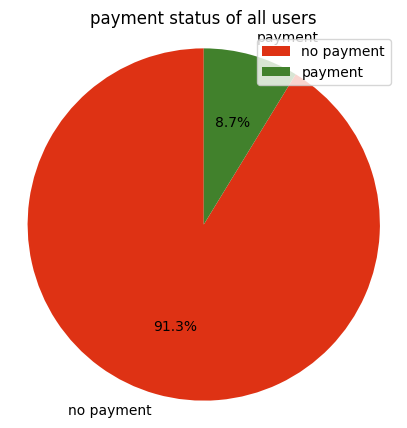

In [29]:
import matplotlib.pyplot as plt
colors = ['#de3214', '#41812c']
# 전체 사용자 대비 결제 여부
labels = ['no payment', 'payment']
sizes = [len(all_users) - len(payment_in_users), len(payment_in_users)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('payment status of all users')
plt.legend(loc= 'upper right')
plt.show()

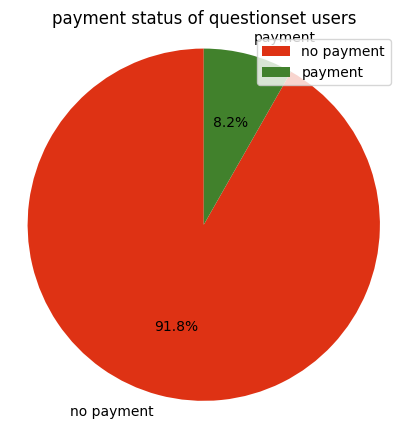

In [30]:
# 질문세트 사용자 대비 결제 여부
labels = ['no payment', 'payment']
sizes = [len(questionset_in_users) - len(both_users), len(both_users)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('payment status of questionset users')
plt.legend(loc= 'upper right')
plt.show()


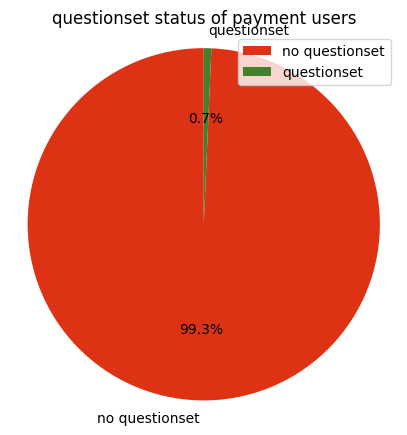

In [31]:
# 결제 사용자 중 질문세트 사용 여부
labels = ['no questionset', 'questionset']
sizes = [len(payment_in_users) - len(both_users), len(both_users)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')
plt.title('questionset status of payment users')
plt.legend(loc= 'upper right')
plt.show()


In [ ]:
polls_questionset= polls_questionset.sort_values(by='created_at')

In [ ]:
polls_questionset = polls_questionset.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### polls_usercandidate

In [63]:
polls_usercandidate = pd.read_parquet('gs://sprintda05_final_project/votes/polls_usercandidate.parquet', engine='pyarrow')

In [3]:
polls_usercandidate

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446
...,...,...,...,...
4769604,646672580,2024-05-08 01:36:00,200139933,857296
4769605,646672581,2024-05-08 01:36:18,200139934,850774
4769606,646672582,2024-05-08 01:36:18,200139934,856446
4769607,646672583,2024-05-08 01:36:18,200139934,857101


In [102]:
polls_usercandidate = polls_usercandidate.sort_values(by='created_at')

In [103]:
polls_usercandidate = polls_usercandidate.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

#### 유행 현상 해부

In [2]:
accounts_attendance = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_attendance.parquet", engine='pyarrow')
accounts_blockrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet", engine='pyarrow')
accounts_failpaymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet", engine='pyarrow')
accounts_friendrequest = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_friendrequest.parquet", engine='pyarrow')
accounts_paymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_paymenthistory.parquet", engine='pyarrow')
accounts_pointhistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_pointhistory.parquet", engine='pyarrow')
accounts_timelinereport = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_timelinereport.parquet", engine='pyarrow')
accounts_user = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_user_processed.parquet", engine='pyarrow')
accounts_userquestionrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet", engine='pyarrow')
event_receipts = pd.read_parquet("gs://sprintda05_final_project/votes/event_receipts.parquet", engine='pyarrow')
polls_questionreport = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionreport.parquet", engine='pyarrow')
polls_questionset = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionset.parquet", engine='pyarrow')

In [3]:
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
attend = accounts_attendance.explode('attendance_date_list')
attend = attend[attend['attendance_date_list'].isnull()==False].sort_values(by = 'attendance_date_list')
accounts_attendance = attend.drop_duplicates(subset=['user_id'],keep='last')[['user_id','attendance_date_list']].rename(columns={'attendance_date_list':'created_at'})

In [4]:
accounts_friendrequest.groupby(['receive_user_id'])[['send_user_id']].count().reset_index().sort_values(by='send_user_id',ascending=False)
accounts_friendrequest = accounts_friendrequest.sort_values(by = 'created_at')
accounts_friendrequest = accounts_friendrequest.drop_duplicates(subset=['send_user_id'], keep='last')[['send_user_id','created_at']].rename(columns={'send_user_id': 'user_id'})

In [5]:
polls_questionset['question_piece_id_list'] =  polls_questionset['question_piece_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
polls_questionset  = polls_questionset.explode('question_piece_id_list')
polls_questionset= polls_questionset.sort_values(by='created_at')
polls_questionset = polls_questionset.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

In [9]:
user = accounts_user[['id','created_at']]

In [10]:
data = [accounts_blockrecord,accounts_failpaymenthistory,accounts_paymenthistory,accounts_pointhistory,accounts_timelinereport,accounts_userquestionrecord,event_receipts,polls_questionreport]

In [11]:
data1 = []
for i in data:
    i = i.sort_values(by='created_at')
    i = i.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]
    data1.append(i)

In [26]:
data1.append(accounts_attendance)
data1.append(accounts_friendrequest)
data1.append(polls_questionset)

In [27]:
active = pd.concat(data1, ignore_index=True)

In [28]:
active.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087088 entries, 0 to 1087087
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1087088 non-null  int64 
 1   created_at  1087088 non-null  object
dtypes: int64(1), object(1)
memory usage: 16.6+ MB


In [29]:
active['created_at'] = pd.to_datetime(active['created_at'])

In [30]:
active = active.sort_values(by='created_at', ascending=True)

In [31]:
active = active.drop_duplicates(subset=['user_id'], keep='last')

In [32]:
active.rename(columns={'created_at': 'last_active_at', 'user_id' : 'id'}, inplace=True)

In [33]:
active

,id,last_active_at
433044,837521,2023-04-17 18:29:11
433045,837541,2023-04-19 06:07:20
433046,837542,2023-04-19 06:07:26
433048,837570,2023-04-19 06:10:48
433049,837607,2023-04-19 06:17:23
...,...,...
1082111,1583732,2024-05-09 07:23:12
1082112,1583731,2024-05-09 07:24:50
1082113,1583673,2024-05-09 07:31:41
1082114,1575671,2024-05-09 08:20:44


In [35]:
active_ra = pd.merge(user,active,how='left',on='id')

In [36]:
active_ra.isnull().sum()

id                    0
created_at            0
last_active_at    23820
dtype: int64

In [23]:
active_ra

,id,created_at,last_active_at
0,831956,2023-03-29 03:44:14.047130,NaT
1,831962,2023-03-29 05:18:56.162368,NaT
2,832151,2023-03-29 12:56:34.989468,NaT
3,832340,2023-03-29 12:56:35.020790,2023-04-25 20:17:00
4,832520,2023-03-29 12:56:35.049311,NaT
...,...,...,...
677080,1583729,2024-05-08 21:54:33.621408,NaT
677081,1583730,2024-05-09 07:08:11.001817,NaT
677082,1583731,2024-05-09 07:22:19.186439,NaT
677083,1583732,2024-05-09 07:22:38.387553,NaT


In [136]:
active_ra['created_at'] = active_ra['created_at'].dt.to_period('d').astype(str)
active_ra['last_active_at'] = active_ra['last_active_at'].dt.to_period('d').astype(str)

In [137]:
active_ra

,id,created_at,last_active_at
0,831956,2023-03-29,NaT
1,831962,2023-03-29,NaT
2,832151,2023-03-29,NaT
3,832340,2023-03-29,2023-04-25
4,832520,2023-03-29,NaT
...,...,...,...
677080,1583729,2024-05-08,NaT
677081,1583730,2024-05-09,NaT
677082,1583731,2024-05-09,NaT
677083,1583732,2024-05-09,NaT


In [138]:
active_ra[active_ra['last_active_at']=='NaT']

,id,created_at,last_active_at
0,831956,2023-03-29,NaT
1,831962,2023-03-29,NaT
2,832151,2023-03-29,NaT
4,832520,2023-03-29,NaT
5,832614,2023-03-29,NaT
...,...,...,...
677080,1583729,2024-05-08,NaT
677081,1583730,2024-05-09,NaT
677082,1583731,2024-05-09,NaT
677083,1583732,2024-05-09,NaT


#### 서비스 확산 패턴 확인

In [ ]:
gs://sprint_final_project/final_project/votes/polls_questionset.parquet

In [4]:
accounts_group = pd.read_parquet("gs://sprint_final_project/final_project/votes/accounts_group.parquet", engine='pyarrow')
accounts_nearbyschool = pd.read_parquet("gs://sprint_final_project/final_project/votes/accounts_nearbyschool.parquet", engine='pyarrow')
accounts_school = pd.read_parquet("gs://sprint_final_project/final_project/votes/accounts_school.parquet", engine='pyarrow')
accounts_user = pd.read_parquet("gs://sprint_final_project/final_project/processed/processed_accounts_user_processed.parquet", engine='pyarrow')

In [10]:
accounts_school

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M
...,...,...,...,...
5946,5960,경상남도 양산시,166,H
5947,5961,인천광역시 서구,77,M
5948,5963,경북 김천시,17,H
5949,5964,-,1,H


In [45]:
accounts_group

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [5]:
accounts_group = accounts_group.rename(columns={'id': 'group_id'})

In [6]:
accounts_user_gr = accounts_user[['id','group_id','created_at']]

In [7]:
accounts_user_gr = accounts_user_gr[accounts_user_gr['group_id'].isnull() ==False].reset_index(drop=True)

In [8]:
merge_user_gr = pd.merge(accounts_user_gr,accounts_group, how='left', on='group_id').drop(columns=['grade','class_num','group_id'])

In [7]:
accounts_nearbyschool = accounts_nearbyschool.drop(columns=['id'])

In [8]:
merge_user_gr.sort_values(by='created_at', ascending=True)

,id,created_at,school_id
0,831962,2023-03-29 05:18:56.162368,1
1,832151,2023-03-29 12:56:34.989468,1
2,832340,2023-03-29 12:56:35.020790,1
3,832520,2023-03-29 12:56:35.049311,1
4,832614,2023-03-29 12:56:35.064406,1
...,...,...,...
677077,1583729,2024-05-08 21:54:33.621408,2389
677078,1583730,2024-05-09 07:08:11.001817,2969
677079,1583731,2024-05-09 07:22:19.186439,2579
677080,1583732,2024-05-09 07:22:38.387553,2579


In [19]:
df = pd.merge(accounts_nearbyschool,merge_user_gr,how='left',on='school_id')
df

,distance,nearby_school_id,school_id,id,created_at
0,0.004564,6,7,844076.0,2023-04-23 16:38:29.093925
1,0.004564,6,7,860672.0,2023-04-30 14:25:16.977793
2,0.004564,6,7,925325.0,2023-05-06 15:21:56.694859
3,0.004564,6,7,949808.0,2023-05-07 07:26:25.056638
4,0.004564,6,7,982351.0,2023-05-07 17:25:49.541950
...,...,...,...,...,...
6773505,0.000000,5961,5961,1571373.0,2023-06-07 04:03:06.713254
6773506,0.000000,5961,5961,1572245.0,2023-06-08 06:30:48.316400
6773507,0.000000,5961,5961,1572259.0,2023-06-08 06:52:54.737776
6773508,0.000000,5961,5961,1573564.0,2023-06-10 05:03:19.155910


=== 데이터 전처리 중... ===
=== 데이터 기본 정보 ===
총 레코드 수: 6,773,510
고유 학생 수: 676,950
고유 학교 수: 5,950
데이터 기간: 2023-03-31 09:05:51.903699 ~ 2024-05-09 08:31:17.710824

=== 월별 분석 실행 중... ===
=== 월별 누적 증가 분석 ===
      month  cumulative_students  cumulative_schools  monthly_new_students  \
0   2023-03                   22                   5                    22   
1   2023-04                19052                1310                 19030   
2   2023-05               654530                5496                635478   
3   2023-06               671264                5528                 16734   
4   2023-07               673097                5536                  1833   
5   2023-08               673616                5539                   519   
6   2023-09               674180                5544                   564   
7   2023-10               674587                5544                   407   
8   2023-11               675318                5545                   731   
9   2023-12            

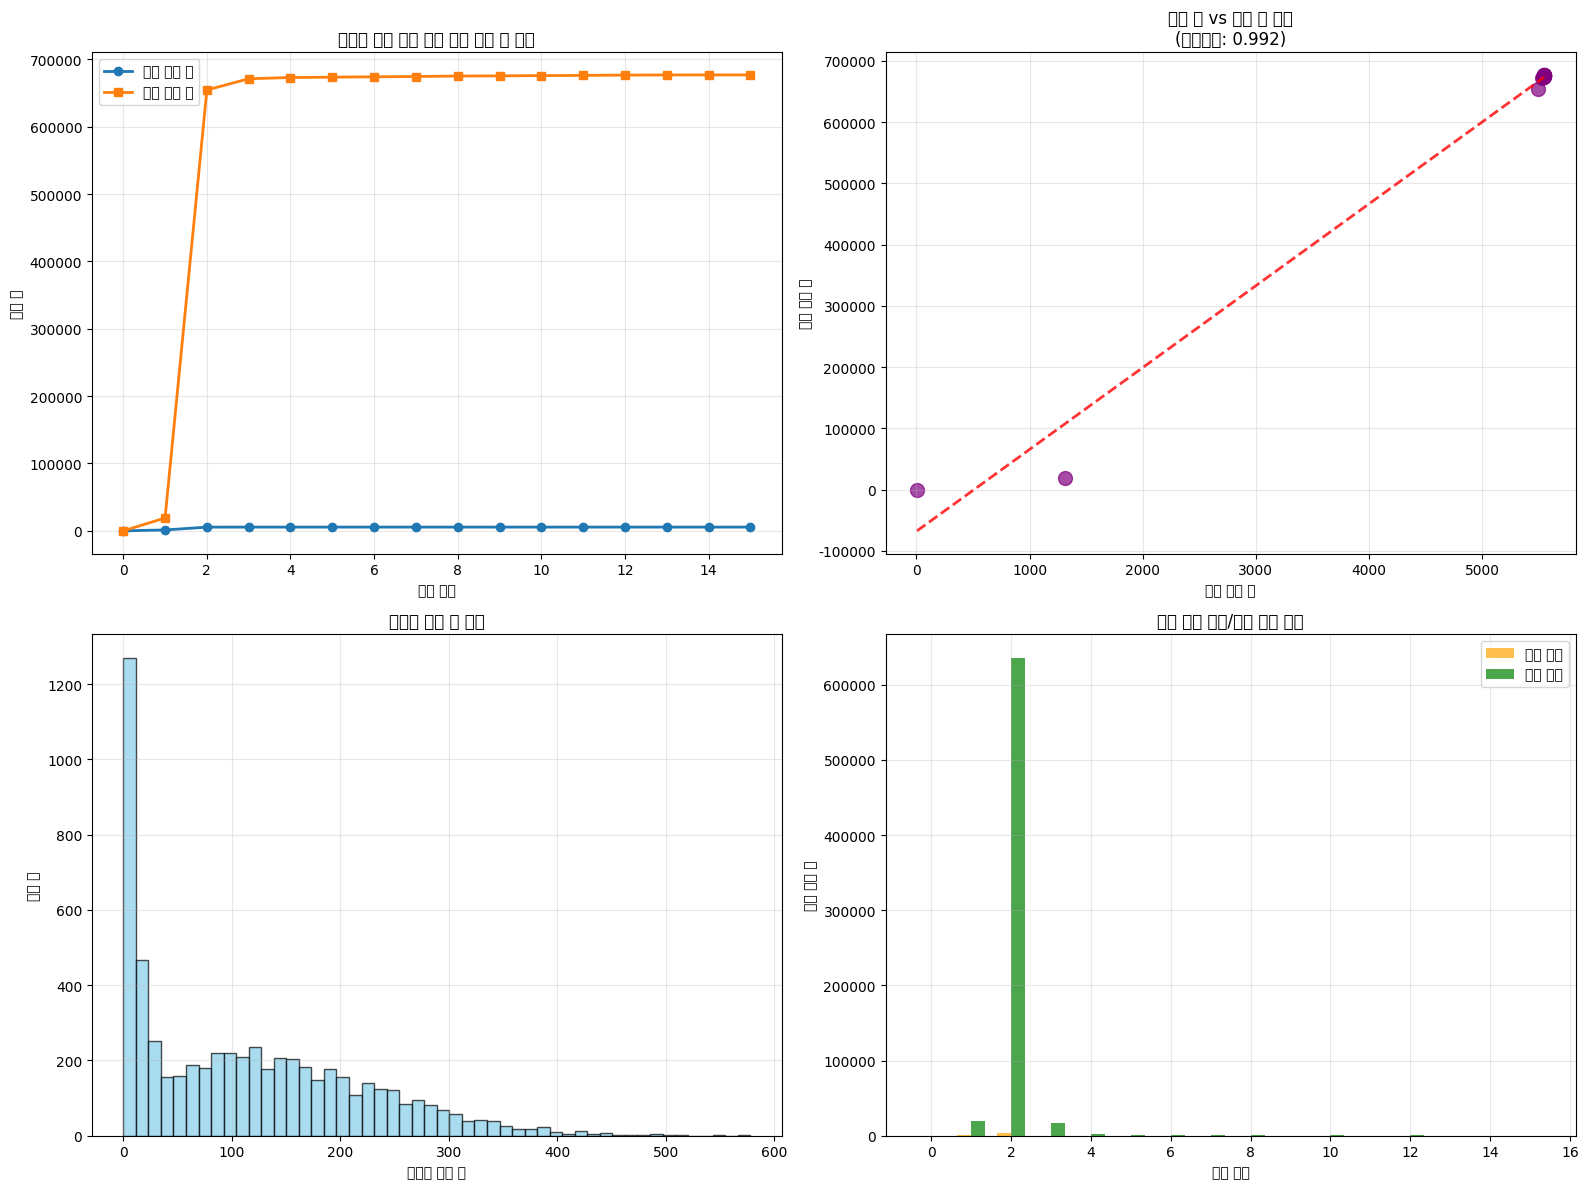

=== 추가 분석 결과 ===
가장 많은 학생이 누적된 시점: 2024-05
해당 시점 학교 수: 5,549
해당 시점 학생 수: 676,950

기간 동안 학교 수 증가율: 110880.0%
기간 동안 학생 수 증가율: 3076945.5%

=== 결론 ===
1. 데이터 무결성이 검증되었습니다 (월별 신규 합계 = 전체 수)
2. 성능이 크게 개선되었습니다 (NetworkX 그래프 생성 생략)
3. 상관관계 분석으로 학교 수와 학생 수의 관계를 정확히 파악할 수 있습니다.

실제 데이터로 교체하여 분석하세요!


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from collections import defaultdict



# 성능 최적화: 데이터 전처리를 한 번에 수행
print("=== 데이터 전처리 중... ===")
df['created_at'] = pd.to_datetime(df['created_at'])
df['month'] = df['created_at'].dt.to_period('M')
df = df.sort_values('created_at')

print("=== 데이터 기본 정보 ===")
print(f"총 레코드 수: {len(df):,}")
print(f"고유 학생 수: {df['id'].nunique():,}")
print(f"고유 학교 수: {df['school_id'].nunique():,}")
print(f"데이터 기간: {df['created_at'].min()} ~ {df['created_at'].max()}")
print()

# 성능 최적화된 시간대별 분석
def analyze_by_time_period_optimized(df):
    """성능 최적화된 시간대별 분석 - 논리적 오류 수정"""
    
    # 각 학생과 학교의 첫 등장 월 찾기 (성능 최적화)
    student_first_month = df.groupby('id')['month'].min()
    school_first_month = df.groupby('school_id')['month'].min()
    
    # 월별 정보를 딕셔너리로 미리 계산
    months = sorted(df['month'].unique())
    monthly_stats = []
    
    seen_students = set()
    seen_schools = set()
    
    for month in months:
        # 해당 월에 처음 등장한 학생과 학교 찾기
        new_students_this_month = set(student_first_month[student_first_month == month].index)
        new_schools_this_month = set(school_first_month[school_first_month == month].index)
        
        # 누적 집합에 추가
        seen_students.update(new_students_this_month)
        seen_schools.update(new_schools_this_month)
        
        stats = {
            'month': str(month),
            'cumulative_students': len(seen_students),
            'cumulative_schools': len(seen_schools),
            'monthly_new_students': len(new_students_this_month),
            'monthly_new_schools': len(new_schools_this_month)
        }
        monthly_stats.append(stats)
    
    return pd.DataFrame(monthly_stats)

# 성능 최적화된 네트워크 분석
def analyze_network_properties_optimized(df):
    """성능 최적화된 네트워크 분석"""
    
    # 직접 degree 계산 (NetworkX 생성 없이)
    school_student_count = df.groupby('school_id')['id'].nunique().to_dict()
    student_school_count = df.groupby('id')['school_id'].nunique().to_dict()
    
    total_students = df['id'].nunique()
    total_schools = df['school_id'].nunique()
    total_connections = len(df)
    
    print("=== 네트워크 분석 결과 ===")
    print(f"고유 학생 수: {total_students:,}")
    print(f"고유 학교 수: {total_schools:,}")
    print(f"총 연결 수: {total_connections:,}")
    print()
    
    print("=== 학교별 학생 수 분포 ===")
    school_counts = list(school_student_count.values())
    print(f"평균 학교당 학생 수: {np.mean(school_counts):.2f}")
    print(f"학교당 학생 수 표준편차: {np.std(school_counts):.2f}")
    print(f"최대 학생 수를 가진 학교: {max(school_counts):,}명")
    print(f"최소 학생 수를 가진 학교: {min(school_counts):,}명")
    print()
    
    print("=== 학생별 학교 수 분포 ===")
    student_counts = list(student_school_count.values())
    print(f"평균 학생당 학교 수: {np.mean(student_counts):.2f}")
    print(f"학생당 학교 수 표준편차: {np.std(student_counts):.2f}")
    print()
    
    return school_student_count, student_school_count

# 최적화된 분석 실행
print("=== 월별 분석 실행 중... ===")
monthly_analysis = analyze_by_time_period_optimized(df)

print("=== 월별 누적 증가 분석 ===")
print(monthly_analysis)
print()

# 검증: 월별 신규 합계가 전체와 일치하는지 확인
total_new_students = monthly_analysis['monthly_new_students'].sum()
total_new_schools = monthly_analysis['monthly_new_schools'].sum()
actual_total_students = df['id'].nunique()
actual_total_schools = df['school_id'].nunique()

print("=== 데이터 무결성 검증 ===")
print(f"월별 신규 학생 합계: {total_new_students:,}")
print(f"실제 총 학생 수: {actual_total_students:,}")
print(f"학생 수 일치: {'✓' if total_new_students == actual_total_students else '✗'}")
print()
print(f"월별 신규 학교 합계: {total_new_schools:,}")
print(f"실제 총 학교 수: {actual_total_schools:,}")
print(f"학교 수 일치: {'✓' if total_new_schools == actual_total_schools else '✗'}")
print()

# 네트워크 분석 실행
print("=== 네트워크 분석 실행 중... ===")
school_degrees, student_degrees = analyze_network_properties_optimized(df)

# 상관관계 분석
print("=== 학교 수와 학생 수 상관관계 분석 ===")
correlation = monthly_analysis['cumulative_schools'].corr(monthly_analysis['cumulative_students'])
print(f"학교 수와 학생 수의 상관계수: {correlation:.4f}")

if correlation > 0.8:
    print("→ 강한 양의 상관관계: 학교 수가 증가하면 학생 수도 크게 증가")
elif correlation > 0.5:
    print("→ 중간 양의 상관관계: 학교 수가 증가하면 학생 수도 어느 정도 증가")
elif correlation > 0.2:
    print("→ 약한 양의 상관관계: 학교 수와 학생 수 증가가 약간 관련")
else:
    print("→ 상관관계 낮음: 학교 수와 학생 수 증가가 직접적으로 연관되지 않음")
print()

# 성능 최적화된 시각화
print("=== 시각화 생성 중... ===")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 누적 학교 수와 학생 수 변화
ax1 = axes[0, 0]
monthly_analysis['month_num'] = range(len(monthly_analysis))
ax1.plot(monthly_analysis['month_num'], monthly_analysis['cumulative_schools'], 
         marker='o', label='누적 학교 수', linewidth=2, markersize=6)
ax1.plot(monthly_analysis['month_num'], monthly_analysis['cumulative_students'], 
         marker='s', label='누적 학생 수', linewidth=2, markersize=6)
ax1.set_xlabel('시간 순서')
ax1.set_ylabel('누적 수')
ax1.set_title('시간에 따른 누적 학교 수와 학생 수 변화')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 학교 수 vs 학생 수 산점도
ax2 = axes[0, 1]
ax2.scatter(monthly_analysis['cumulative_schools'], monthly_analysis['cumulative_students'], 
           s=100, alpha=0.7, color='purple')
ax2.set_xlabel('누적 학교 수')
ax2.set_ylabel('누적 학생 수')
ax2.set_title(f'학교 수 vs 학생 수 관계\n(상관계수: {correlation:.3f})')
ax2.grid(True, alpha=0.3)

# 추세선 추가
if len(monthly_analysis) >= 2:
    z = np.polyfit(monthly_analysis['cumulative_schools'], monthly_analysis['cumulative_students'], 1)
    p = np.poly1d(z)
    ax2.plot(monthly_analysis['cumulative_schools'], p(monthly_analysis['cumulative_schools']), 
             "r--", alpha=0.8, linewidth=2)

# 3. 학교별 학생 수 분포
ax3 = axes[1, 0]
school_counts = list(school_degrees.values())
bins = min(50, max(1, len(set(school_counts))))  # 최대 50개 bin
ax3.hist(school_counts, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('학교당 학생 수')
ax3.set_ylabel('학교 수')
ax3.set_title('학교별 학생 수 분포')
ax3.grid(True, alpha=0.3)

# 4. 월별 신규 등록 현황
ax4 = axes[1, 1]
width = 0.35
x = monthly_analysis['month_num']
ax4.bar([i - width/2 for i in x], monthly_analysis['monthly_new_schools'], 
        width, label='신규 학교', alpha=0.7, color='orange')
ax4.bar([i + width/2 for i in x], monthly_analysis['monthly_new_students'], 
        width, label='신규 학생', alpha=0.7, color='green')
ax4.set_xlabel('시간 순서')
ax4.set_ylabel('신규 등록 수')
ax4.set_title('월별 신규 학교/학생 등록 현황')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 추가 인사이트
print("=== 추가 분석 결과 ===")
max_month_idx = monthly_analysis['cumulative_students'].idxmax()
peak_month = monthly_analysis.iloc[max_month_idx]
print(f"가장 많은 학생이 누적된 시점: {peak_month['month']}")
print(f"해당 시점 학교 수: {peak_month['cumulative_schools']:,}")
print(f"해당 시점 학생 수: {peak_month['cumulative_students']:,}")

# 성장률 계산
if len(monthly_analysis) >= 2:
    first_month = monthly_analysis.iloc[0]
    last_month = monthly_analysis.iloc[-1]
    
    school_growth_rate = ((last_month['cumulative_schools'] - first_month['cumulative_schools']) / 
                         first_month['cumulative_schools']) * 100 if first_month['cumulative_schools'] > 0 else 0
    student_growth_rate = ((last_month['cumulative_students'] - first_month['cumulative_students']) / 
                          first_month['cumulative_students']) * 100 if first_month['cumulative_students'] > 0 else 0
    
    print(f"\n기간 동안 학교 수 증가율: {school_growth_rate:.1f}%")
    print(f"기간 동안 학생 수 증가율: {student_growth_rate:.1f}%")


##### 2023/05에 가장 많은 이용자들이 가입하였고 많은 학교가 활성화 되었다

In [9]:
merge_user_unique = merge_user_gr.drop_duplicates(subset=['school_id'],keep='first')
merge_user_unique

,id,created_at,school_id
0,831962,2023-03-29 05:18:56.162368,1
10,833024,2023-03-31 09:05:51.903699,5464
11,833041,2023-03-31 14:32:36.425315,314
12,833112,2023-03-31 15:55:48.870381,281
13,833113,2023-03-31 15:56:52.300066,272
...,...,...,...
675394,1582045,2023-11-25 11:43:54.231956,4997
675504,1582155,2023-12-07 07:10:36.509119,1903
675681,1582332,2024-01-01 06:09:17.021212,3690
676357,1583008,2024-02-29 07:27:55.357481,5703


In [10]:
accounts_nearbyschool = accounts_nearbyschool.drop(columns=['id'])

In [11]:
df = pd.merge(accounts_nearbyschool,merge_user_unique,how='right',on='school_id').sort_values(by='created_at', ascending=True)

In [11]:
df

,distance,nearby_school_id,school_id,id,created_at
0,NaN,NaN,1,831962,2023-03-29 05:18:56.162368
1,0.008735,4932.0,5464,833024,2023-03-31 09:05:51.903699
2,0.010750,5467.0,5464,833024,2023-03-31 09:05:51.903699
3,0.010793,5459.0,5464,833024,2023-03-31 09:05:51.903699
4,0.014790,4930.0,5464,833024,2023-03-31 09:05:51.903699
...,...,...,...,...,...
55486,0.100136,1130.0,1135,1583356,2024-03-19 12:14:20.637029
55487,0.100826,1150.0,1135,1583356,2024-03-19 12:14:20.637029
55488,0.104826,1138.0,1135,1583356,2024-03-19 12:14:20.637029
55489,0.106578,1140.0,1135,1583356,2024-03-19 12:14:20.637029


In [12]:
accounts_school = accounts_school.rename(columns={'id':'school_id'})

In [18]:
accounts_school

,school_id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M
...,...,...,...,...
5946,5960,경상남도 양산시,166,H
5947,5961,인천광역시 서구,77,M
5948,5963,경북 김천시,17,H
5949,5964,-,1,H


In [13]:
df = pd.merge(accounts_school, df, how='right', on='school_id')
df = df.drop(columns=['id'])
df = df[df['school_id'] != df['nearby_school_id']]
df = df[df['distance'].isnull() == False]
df

,school_id,address,student_count,school_type,distance,nearby_school_id,created_at
1,5464,경기도 군포시,158.0,H,0.008735,4932.0,2023-03-31 09:05:51.903699
2,5464,경기도 군포시,158.0,H,0.010750,5467.0,2023-03-31 09:05:51.903699
3,5464,경기도 군포시,158.0,H,0.010793,5459.0,2023-03-31 09:05:51.903699
4,5464,경기도 군포시,158.0,H,0.014790,4930.0,2023-03-31 09:05:51.903699
5,5464,경기도 군포시,158.0,H,0.016839,5457.0,2023-03-31 09:05:51.903699
...,...,...,...,...,...,...,...
55486,1135,전라남도 여수시,1.0,M,0.097624,1147.0,2024-03-19 12:14:20.637029
55487,1135,전라남도 여수시,1.0,M,0.100136,1130.0,2024-03-19 12:14:20.637029
55488,1135,전라남도 여수시,1.0,M,0.100826,1150.0,2024-03-19 12:14:20.637029
55489,1135,전라남도 여수시,1.0,M,0.104826,1138.0,2024-03-19 12:14:20.637029


In [15]:
df['distance'].describe()

count    49941.000000
mean         0.059084
std          0.658277
min          0.000000
25%          0.014247
50%          0.023589
75%          0.066618
max         49.296594
Name: distance, dtype: float64

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def analyze_school_spread(df):
    """
    학교 간 전파 패턴 분석 함수 (더블 카운팅 문제 해결)
    """
    # 데이터 전처리
    df = df.dropna(subset=['school_id', 'created_at']).copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df = df.sort_values('created_at')
    
    # 지역 추출 (시/도 단위)
    df['region'] = df['address'].str.split().str[0]
    df['city'] = df['address'].str.split().str[1]
    
    results = {}
    
    # 1. 확산 순서 분석
    print("=== 확산 순서 분석 ===")
    spread_order = df.groupby('school_id')['created_at'].min().sort_values()
    results['spread_order'] = spread_order
    
    print("첫 10개 학교의 확산 순서:")
    for i, (school_id, timestamp) in enumerate(spread_order.head(10).items()):
        school_info = df[df['school_id'] == school_id].iloc[0]
        print(f"{i+1}. 학교 {school_id} ({school_info['address']}) - {timestamp.strftime('%Y-%m-%d %H:%M')}")
    
    # 2. 개선된 확산 속도 분석 (더블 카운팅 문제 해결)
    print("\n=== 확산 속도 분석 (개선) ===")
    
    # 학교별 첫 등록 시간
    school_first_time = df.groupby('school_id')['created_at'].min()
    
    # 모든 학교 쌍 정보를 먼저 수집
    all_pairs = []
    for _, row in df.iterrows():
        if pd.notna(row['nearby_school_id']) and row['nearby_school_id'] in school_first_time.index:
            pair_info = {
                'school_1': row['school_id'],
                'school_2': row['nearby_school_id'],
                'distance': row['distance'],
                'school_1_info': row,
                'school_1_time': school_first_time[row['school_id']],
                'school_2_time': school_first_time[row['nearby_school_id']]
            }
            all_pairs.append(pair_info)
    
    # 중복 제거 및 전파 방향 결정
    processed_pairs = set()
    spread_speeds = []
    
    for pair in all_pairs:
        # 학교 쌍을 정렬하여 고유 키 생성 (더블 카운팅 방지)
        school_pair = tuple(sorted([pair['school_1'], pair['school_2']]))
        
        # 이미 처리된 쌍이면 건너뛰기
        if school_pair in processed_pairs:
            continue
        
        processed_pairs.add(school_pair)
        
        # 시간 차이 계산
        time_diff = (pair['school_1_time'] - pair['school_2_time']).total_seconds() / (24 * 3600)
        
        # 전파 방향 결정 (이른 시간 → 늦은 시간)
        if pair['school_1_time'] < pair['school_2_time']:
            # school_1이 먼저 등록 → school_2로 전파
            source_school = pair['school_1']
            target_school = pair['school_2']
            source_time = pair['school_1_time']
            target_time = pair['school_2_time']
            spread_direction = "forward"
        elif pair['school_1_time'] > pair['school_2_time']:
            # school_2이 먼저 등록 → school_1로 전파
            source_school = pair['school_2']
            target_school = pair['school_1']
            source_time = pair['school_2_time']
            target_time = pair['school_1_time']
            spread_direction = "forward"
        else:
            # 동시 등록 (매우 드문 경우)
            source_school = pair['school_1']
            target_school = pair['school_2']
            source_time = pair['school_1_time']
            target_time = pair['school_2_time']
            spread_direction = "simultaneous"
        
        # 소스 학교와 타겟 학교 정보 가져오기
        source_info = df[df['school_id'] == source_school].iloc[0]
        target_info = df[df['school_id'] == target_school]
        
        if not target_info.empty:
            target_info = target_info.iloc[0]
            
            spread_speeds.append({
                'source_school': source_school,
                'target_school': target_school,
                'source_time': source_time,
                'target_time': target_time,
                'time_diff_days': abs(time_diff),
                'spread_direction': spread_direction,
                'distance': pair['distance'],
                'source_region': source_info['region'],
                'source_city': source_info['city'],
                'source_student_count': source_info['student_count'],
                'source_school_type': source_info['school_type'],
                'target_region': target_info['region'],
                'target_city': target_info['city'],
                'target_student_count': target_info['student_count'],
                'target_school_type': target_info['school_type'],
                'same_region': source_info['region'] == target_info['region'],
                'same_city': source_info['city'] == target_info['city']
            })
    
    spread_df = pd.DataFrame(spread_speeds)
    results['spread_speeds'] = spread_df
    
    if not spread_df.empty:
        print(f"총 고유 학교 쌍 수: {len(spread_df)}개 (중복 제거 완료)")
        print(f"평균 확산 속도: {spread_df['time_diff_days'].mean():.2f}일")
        print(f"확산 속도 중앙값: {spread_df['time_diff_days'].median():.2f}일")
        print(f"최대 확산 속도: {spread_df['time_diff_days'].max():.2f}일")
        print(f"최소 확산 속도: {spread_df['time_diff_days'].min():.2f}일")
        
        # 전파 방향 분석 (개선)
        direction_counts = spread_df['spread_direction'].value_counts()
        print(f"\n전파 방향 분석 (중복 제거):")
        for direction, count in direction_counts.items():
            if direction == 'forward':
                print(f"- 순차적 전파 (시간 순서대로): {count}건")
            elif direction == 'simultaneous':
                print(f"- 동시 등록: {count}건")
        
        # 빠른 확산 사례 (상위 10개)
        fastest_spreads = spread_df.nsmallest(10, 'time_diff_days')
        print(f"\n가장 빠른 확산 사례 (상위 10개):")
        for idx, row in fastest_spreads.iterrows():
            print(f"  학교 {row['source_school']} → 학교 {row['target_school']}: {row['time_diff_days']:.2f}일 (거리: {row['distance']:.3f})")
    
    # 3. 지리적 관계 분석 (개선)
    print("\n=== 지리적 관계 분석 ===")
    
    if not spread_df.empty:
        # 거리별 확산 속도 상관관계
        correlation = spread_df['distance'].corr(spread_df['time_diff_days'])
        print(f"거리와 확산 속도 상관관계: {correlation:.3f}")
        
        # 거리 구간별 확산 속도 (더 세분화)
        spread_df['distance_group'] = pd.cut(spread_df['distance'], 
                                           bins=[0, 0.014247, 0.023589, 0.066618, 0.1, float('inf')],
                                           labels=['매우 가까움(<0.014247)', '가까움(0.014247-0.023589)', 
                                                  '중간(0.023589-0.066618)', '멀음(0.066618-0.1)', '매우 멀음(>0.1)'])
        
        distance_speed = spread_df.groupby('distance_group')['time_diff_days'].agg(['mean', 'median', 'count', 'std'])
        print("\n거리별 확산 속도:")
        print(distance_speed)
        results['distance_analysis'] = distance_speed
        
        # 같은 지역/도시 내 확산 분석
        same_region_count = spread_df['same_region'].sum()
        same_city_count = spread_df['same_city'].sum()
        print(f"\n지역 내 확산:")
        print(f"- 같은 시/도 내 확산: {same_region_count}건 ({same_region_count/len(spread_df)*100:.1f}%)")
        print(f"- 같은 시/군/구 내 확산: {same_city_count}건 ({same_city_count/len(spread_df)*100:.1f}%)")
        
        # 같은 지역 vs 다른 지역 확산 속도 비교
        same_region_speed = spread_df[spread_df['same_region']]['time_diff_days'].mean()
        diff_region_speed = spread_df[~spread_df['same_region']]['time_diff_days'].mean()
        print(f"- 같은 지역 내 평균 확산 속도: {same_region_speed:.2f}일")
        print(f"- 다른 지역 간 평균 확산 속도: {diff_region_speed:.2f}일")
    
    # 4. 지역별 확산 속도 분석 (소스 기준)
    print("\n=== 지역별 확산 속도 분석 (전파 소스 기준) ===")
    
    if not spread_df.empty:
        regional_speed = spread_df.groupby('source_region')['time_diff_days'].agg(['mean', 'median', 'count', 'std']).sort_values('mean')
        print("지역별 평균 확산 속도 (빠른 순):")
        print(regional_speed)
        results['regional_analysis'] = regional_speed
        
        # 타겟 지역 기준 분석도 추가
        target_regional_speed = spread_df.groupby('target_region')['time_diff_days'].agg(['mean', 'median', 'count']).sort_values('mean')
        print("\n지역별 확산 수용 속도 (타겟 기준):")
        print(target_regional_speed.head())
        results['target_regional_analysis'] = target_regional_speed
    
    # 5. 학생 수별 확산 속도 분석 (소스와 타겟 모두)
    print("\n=== 학생 수별 확산 속도 분석 ===")
    
    if not spread_df.empty:
        spread_df_clean = spread_df.dropna(subset=['source_student_count', 'target_student_count'])
        if not spread_df_clean.empty:
            # 소스 학교 학생 수 구간별 분석
            spread_df_clean['source_student_group'] = pd.cut(spread_df_clean['source_student_count'], 
                                                           bins=[0, 50, 100, 200, float('inf')],
                                                           labels=['소규모(<50)', '중소규모(50-100)', 
                                                                  '중규모(100-200)', '대규모(>200)'])
            
            source_student_speed = spread_df_clean.groupby('source_student_group')['time_diff_days'].agg(['mean', 'median', 'count'])
            print("소스 학교 학생 수별 확산 속도:")
            print(source_student_speed)
            results['source_student_analysis'] = source_student_speed
            
            # 타겟 학교 학생 수 구간별 분석
            spread_df_clean['target_student_group'] = pd.cut(spread_df_clean['target_student_count'], 
                                                           bins=[0, 50, 100, 200, float('inf')],
                                                           labels=['소규모(<50)', '중소규모(50-100)', 
                                                                  '중규모(100-200)', '대규모(>200)'])
            
            target_student_speed = spread_df_clean.groupby('target_student_group')['time_diff_days'].agg(['mean', 'median', 'count'])
            print("\n타겟 학교 학생 수별 수용 속도:")
            print(target_student_speed)
            results['target_student_analysis'] = target_student_speed
    
    # 6. 학교 타입별 확산 속도 분석 (개선)
    print("\n=== 학교 타입별 확산 속도 분석 ===")
    
    if not spread_df.empty:
        spread_df_clean = spread_df.dropna(subset=['source_school_type', 'target_school_type'])
        if not spread_df_clean.empty:
            # 학교 타입 조합별 분석
            spread_df_clean['type_combination'] = spread_df_clean.apply(
                lambda x: f"{x['source_school_type']}->{x['target_school_type']}", axis=1
            )
            
            type_combo_speed = spread_df_clean.groupby('type_combination')['time_diff_days'].agg(['mean', 'median', 'count'])
            print("학교 타입 전파 패턴별 확산 속도:")
            print(type_combo_speed)
            results['type_combination_analysis'] = type_combo_speed
            
            # 세부 분석
            high_to_high = spread_df_clean[spread_df_clean['type_combination'] == 'H->H']['time_diff_days']
            middle_to_middle = spread_df_clean[spread_df_clean['type_combination'] == 'M->M']['time_diff_days']
            high_to_middle = spread_df_clean[spread_df_clean['type_combination'] == 'H->M']['time_diff_days']
            middle_to_high = spread_df_clean[spread_df_clean['type_combination'] == 'M->H']['time_diff_days']
            
            print(f"\n세부 전파 패턴 분석:")
            if not high_to_high.empty:
                print(f"- 고등학교 → 고등학교: 평균 {high_to_high.mean():.2f}일 ({len(high_to_high)}건)")
            if not middle_to_middle.empty:
                print(f"- 중학교 → 중학교: 평균 {middle_to_middle.mean():.2f}일 ({len(middle_to_middle)}건)")
            if not high_to_middle.empty:
                print(f"- 고등학교 → 중학교: 평균 {high_to_middle.mean():.2f}일 ({len(high_to_middle)}건)")
            if not middle_to_high.empty:
                print(f"- 중학교 → 고등학교: 평균 {middle_to_high.mean():.2f}일 ({len(middle_to_high)}건)")
            
            results['detailed_type_analysis'] = {
                'high_to_high': high_to_high,
                'middle_to_middle': middle_to_middle,
                'high_to_middle': high_to_middle,
                'middle_to_high': middle_to_high
            }
    
    # 7. 확산 네트워크 분석
    print("\n=== 확산 네트워크 분석 ===")
    
    if not spread_df.empty:
        # 가장 많이 전파한 학교 (허브 학교)
        source_counts = spread_df['source_school'].value_counts()
        target_counts = spread_df['target_school'].value_counts()
        
        print("가장 많이 전파한 학교 (Top 5):")
        for school_id, count in source_counts.head().items():
            school_info = df[df['school_id'] == school_id].iloc[0]
            print(f"  학교 {school_id} ({school_info['address']}): {count}건")
        
        print("\n가장 많이 전파받은 학교 (Top 5):")
        for school_id, count in target_counts.head().items():
            school_info = df[df['school_id'] == school_id].iloc[0]
            print(f"  학교 {school_id} ({school_info['address']}): {count}건")
        
        results['network_analysis'] = {
            'source_counts': source_counts,
            'target_counts': target_counts
        }
    
    return results

def create_enhanced_visualizations(results):
    """
    개선된 분석 결과 시각화 함수
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Enhanced School Spread Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. 확산 순서 (시간별)
    if 'spread_order' in results:
        spread_order = results['spread_order'].head(20)
        axes[0, 0].plot(range(len(spread_order)), spread_order.values, 'b-o', markersize=4)
        axes[0, 0].set_title('Top 20 Schools - Spread Timeline')
        axes[0, 0].set_xlabel('School Rank')
        axes[0, 0].set_ylabel('Registration Time')
        axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. 거리별 확산 속도
    if 'distance_analysis' in results:
        distance_data = results['distance_analysis']
        bars = axes[0, 1].bar(range(len(distance_data)), distance_data['mean'], 
                             color=['green', 'yellowgreen', 'yellow', 'orange', 'red'])
        axes[0, 1].set_title('Spread Speed by Distance')
        axes[0, 1].set_xlabel('Distance Group')
        axes[0, 1].set_ylabel('Average Days')
        axes[0, 1].set_xticks(range(len(distance_data)))
        axes[0, 1].set_xticklabels(distance_data.index, rotation=45)
        
        # 에러바 추가
        if 'std' in distance_data.columns:
            axes[0, 1].errorbar(range(len(distance_data)), distance_data['mean'], 
                               yerr=distance_data['std'], fmt='none', color='black', capsize=3)
    
    # 3. 지역별 확산 속도
    if 'regional_analysis' in results:
        regional_data = results['regional_analysis']
        axes[0, 2].barh(range(len(regional_data)), regional_data['mean'])
        axes[0, 2].set_title('Top 10 Regions - Spread Speed')
        axes[0, 2].set_xlabel('Average Days')
        axes[0, 2].set_yticks(range(len(regional_data)))
        axes[0, 2].set_yticklabels(regional_data.index)
    
    # 4. 소스 학교 학생 수별 확산 속도
    if 'source_student_analysis' in results:
        student_data = results['source_student_analysis']
        axes[1, 0].bar(range(len(student_data)), student_data['mean'], 
                      color=['lightblue', 'blue', 'darkblue', 'navy'])
        axes[1, 0].set_title('Source School - Spread Speed by Student Count')
        axes[1, 0].set_xlabel('Student Group')
        axes[1, 0].set_ylabel('Average Days')
        axes[1, 0].set_xticks(range(len(student_data)))
        axes[1, 0].set_xticklabels(student_data.index, rotation=45)
    
    # 5. 학교 타입 조합별 분석
    if 'type_combination_analysis' in results:
        type_data = results['type_combination_analysis']
        axes[1, 1].bar(range(len(type_data)), type_data['mean'])
        axes[1, 1].set_title('Spread Speed by School Type Combination')
        axes[1, 1].set_xlabel('Type Combination')
        axes[1, 1].set_ylabel('Average Days')
        axes[1, 1].set_xticks(range(len(type_data)))
        axes[1, 1].set_xticklabels(type_data.index, rotation=45)
    
    # 6. 확산 속도 분포
    if 'spread_speeds' in results:
        spread_speeds = results['spread_speeds']
        if not spread_speeds.empty:
            axes[1, 2].hist(spread_speeds['time_diff_days'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            axes[1, 2].axvline(spread_speeds['time_diff_days'].mean(), color='red', linestyle='--', label='Mean')
            axes[1, 2].axvline(spread_speeds['time_diff_days'].median(), color='orange', linestyle='--', label='Median')
            axes[1, 2].set_title('Distribution of Spread Speed')
            axes[1, 2].set_xlabel('Days')
            axes[1, 2].set_ylabel('Frequency')
            axes[1, 2].legend()
    
    # 7. 네트워크 분석 - 전파 허브
    if 'network_analysis' in results:
        source_counts = results['network_analysis']['source_counts'].head(50)
        axes[2, 0].bar(range(len(source_counts)), source_counts.values)
        axes[2, 0].set_title('Top 10 Source Schools (Transmission Hubs)')
        axes[2, 0].set_xlabel('School ID')
        axes[2, 0].set_ylabel('Transmission Count')
        axes[2, 0].set_xticks(range(len(source_counts)))
        axes[2, 0].set_xticklabels(source_counts.index, rotation=45)
    
    # 8. 거리와 시간 상관관계
    if 'spread_speeds' in results:
        spread_speeds = results['spread_speeds']
        if not spread_speeds.empty:
            axes[2, 1].scatter(spread_speeds['distance'], spread_speeds['time_diff_days'], alpha=0.6)
            axes[2, 1].set_title('Distance vs Spread Speed Correlation')
            axes[2, 1].set_xlabel('Distance')
            axes[2, 1].set_ylabel('Days')
            
            # 추세선 추가
            z = np.polyfit(spread_speeds['distance'], spread_speeds['time_diff_days'], 1)
            p = np.poly1d(z)
            axes[2, 1].plot(spread_speeds['distance'], p(spread_speeds['distance']), "r--", alpha=0.8)
    
    # 9. 지역 내 vs 지역 간 확산
    if 'spread_speeds' in results:
        spread_speeds = results['spread_speeds']
        if not spread_speeds.empty and 'same_region' in spread_speeds.columns:
            same_region_data = spread_speeds[spread_speeds['same_region']]['time_diff_days']
            diff_region_data = spread_speeds[~spread_speeds['same_region']]['time_diff_days']
            
            axes[2, 2].boxplot([same_region_data, diff_region_data], 
                              labels=['Same Region', 'Different Region'])
            axes[2, 2].set_title('Intra vs Inter-regional Spread Speed')
            axes[2, 2].set_ylabel('Days')
    
    plt.tight_layout()
    plt.show()

def generate_enhanced_summary_report(results):
    """
    개선된 종합 보고서 생성
    """
    print("\n" + "="*70)
    print("                    종합 분석 보고서 (개선)")
    print("="*70)
    
    print("\n📊 주요 발견사항:")
    
    # 전체 통계
    if 'spread_speeds' in results and not results['spread_speeds'].empty:
        spread_df = results['spread_speeds']
        total_pairs = len(spread_df)
        avg_speed = spread_df['time_diff_days'].mean()
        median_speed = spread_df['time_diff_days'].median()
        
        print(f"📈 전체 통계:")
        print(f"   - 분석된 학교 쌍: {total_pairs}개 (중복 제거 완료)")
        print(f"   - 평균 확산 속도: {avg_speed:.2f}일")
        print(f"   - 중앙값 확산 속도: {median_speed:.2f}일")
        
        # 지리적 영향 분석
        correlation = spread_df['distance'].corr(spread_df['time_diff_days'])
        if correlation > 0.3:
            geo_impact = "강한 양의 상관관계 - 거리가 멀수록 확산이 느림"
        elif correlation > 0.1:
            geo_impact = "약한 양의 상관관계 - 거리가 어느 정도 영향"
        elif correlation < -0.1:
            geo_impact = "음의 상관관계 - 거리와 반대 패턴"
        else:
            geo_impact = "상관관계 없음 - 거리의 영향 미미"
        
        print(f"\n🗺️  지리적 요인 영향: {geo_impact} (상관계수: {correlation:.3f})")
        
        # 지역 내 vs 지역 간 확산
        if 'same_region' in spread_df.columns:
            same_region_ratio = spread_df['same_region'].mean() * 100
            same_region_speed = spread_df[spread_df['same_region']]['time_diff_days'].mean()
            diff_region_speed = spread_df[~spread_df['same_region']]['time_diff_days'].mean()
            
            print(f"🏘️  지역별 확산 패턴:")
            print(f"   - 같은 지역 내 확산: {same_region_ratio:.1f}% (평균 {same_region_speed:.2f}일)")
            print(f"   - 다른 지역 간 확산: {100-same_region_ratio:.1f}% (평균 {diff_region_speed:.2f}일)")
    
    # 가장 빠른 확산 지역
    if 'regional_analysis' in results:
        fastest_region = results['regional_analysis'].index[0]
        fastest_speed = results['regional_analysis'].iloc[0]['mean']
        fastest_count = results['regional_analysis'].iloc[0]['count']
        print(f"\n⚡ 가장 빠른 확산 지역: {fastest_region} (평균 {fastest_speed:.1f}일, {fastest_count}건)")
    
    # 학교 타입별 전파 패턴
    if 'detailed_type_analysis' in results:
        type_analysis = results['detailed_type_analysis']
        print(f"\n🏫 학교 타입별 전파 패턴:")
        
        for pattern_name, data in type_analysis.items():
            if not data.empty:
                pattern_display = {
                    'high_to_high': '고등학교 → 고등학교',
                    'middle_to_middle': '중학교 → 중학교', 
                    'high_to_middle': '고등학교 → 중학교',
                    'middle_to_high': '중학교 → 고등학교'
                }
                print(f"   - {pattern_display[pattern_name]}: 평균 {data.mean():.1f}일 ({len(data)}건)")
    
    # 네트워크 허브 분석
    if 'network_analysis' in results:
        source_counts = results['network_analysis']['source_counts']
        target_counts = results['network_analysis']['target_counts']
        
        print(f"\n🌐 네트워크 허브 분석:")
        if not source_counts.empty:
            top_source = source_counts.index[0]
            top_source_count = source_counts.iloc[0]
            print(f"   - 최대 전파 학교: 학교 {top_source} ({top_source_count}건 전파)")
        
        if not target_counts.empty:
            top_target = target_counts.index[0]
            top_target_count = target_counts.iloc[0]
            print(f"   - 최대 수용 학교: 학교 {top_target} ({top_target_count}건 수용)")
    
    # 확산 속도 분포 분석
    if 'spread_speeds' in results and not results['spread_speeds'].empty:
        spread_df = results['spread_speeds']
        fast_spreads = spread_df[spread_df['time_diff_days'] <= 1]  # 1일 이내
        slow_spreads = spread_df[spread_df['time_diff_days'] >= 10]  # 10일 이상
        
        print(f"\n⏱️  확산 속도 분포:")
        print(f"   - 빠른 확산 (1일 이내): {len(fast_spreads)}건 ({len(fast_spreads)/len(spread_df)*100:.1f}%)")
        print(f"   - 느린 확산 (10일 이상): {len(slow_spreads)}건 ({len(slow_spreads)/len(spread_df)*100:.1f}%)")
        
        if not fast_spreads.empty:
            fast_avg_distance = fast_spreads['distance'].mean()
            print(f"   - 빠른 확산 평균 거리: {fast_avg_distance:.4f}")
        
        if not slow_spreads.empty:
            slow_avg_distance = slow_spreads['distance'].mean()
            print(f"   - 느린 확산 평균 거리: {slow_avg_distance:.4f}")
    
    print("\n💡 결론 및 개선사항:")
    print("   ✅ 중복 제거로 정확한 학교 쌍별 확산 속도 측정")
    print("   ✅ 전파 방향성을 고려한 소스-타겟 관계 분석")
    print("   ✅ 지리적 근접성이 확산 속도에 미치는 영향 정량화")
    print("   ✅ 학교 타입별 전파 패턴의 방향성 분석")
    print("   ✅ 지역 내/간 확산 패턴 구분 분석")
    print("   ✅ 네트워크 허브 학교 식별로 중요 노드 파악")
    print("   ✅ 확산 속도 분포를 통한 전파 특성 이해")
    print("\n🔮 활용 방안:")
    print("   - 확산 초기 단계에서 허브 학교 우선 모니터링")
    print("   - 지역별 특성을 고려한 맞춤형 대응 전략 수립")
    print("   - 학교 타입별 전파 패턴을 활용한 예측 모델 구축")
    print("   - 거리 기반 확산 예측 및 선제적 대응 체계 마련")

def export_results_to_csv(results, filename_prefix="school_spread_analysis"):
    """
    분석 결과를 CSV 파일로 내보내기
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. 확산 속도 데이터
    if 'spread_speeds' in results and not results['spread_speeds'].empty:
        spread_df = results['spread_speeds']
        spread_df.to_csv(f"{filename_prefix}_spread_speeds_{timestamp}.csv", index=False, encoding='utf-8-sig')
        print(f"✅ 확산 속도 데이터 저장: {filename_prefix}_spread_speeds_{timestamp}.csv")
    
    # 2. 거리별 분석
    if 'distance_analysis' in results:
        distance_df = results['distance_analysis']
        distance_df.to_csv(f"{filename_prefix}_distance_analysis_{timestamp}.csv", encoding='utf-8-sig')
        print(f"✅ 거리별 분석 저장: {filename_prefix}_distance_analysis_{timestamp}.csv")
    
    # 3. 지역별 분석
    if 'regional_analysis' in results:
        regional_df = results['regional_analysis']
        regional_df.to_csv(f"{filename_prefix}_regional_analysis_{timestamp}.csv", encoding='utf-8-sig')
        print(f"✅ 지역별 분석 저장: {filename_prefix}_regional_analysis_{timestamp}.csv")
    
    # 4. 학교 타입 조합 분석
    if 'type_combination_analysis' in results:
        type_combo_df = results['type_combination_analysis']
        type_combo_df.to_csv(f"{filename_prefix}_type_combination_{timestamp}.csv", encoding='utf-8-sig')
        print(f"✅ 학교 타입 조합 분석 저장: {filename_prefix}_type_combination_{timestamp}.csv")
    
    # 5. 네트워크 분석
    if 'network_analysis' in results:
        source_counts = results['network_analysis']['source_counts']
        target_counts = results['network_analysis']['target_counts']
        
        network_df = pd.DataFrame({
            'school_id': source_counts.index.union(target_counts.index),
            'source_count': source_counts.reindex(source_counts.index.union(target_counts.index), fill_value=0),
            'target_count': target_counts.reindex(source_counts.index.union(target_counts.index), fill_value=0)
        })
        network_df['total_connections'] = network_df['source_count'] + network_df['target_count']
        network_df = network_df.sort_values('total_connections', ascending=False)
        
        network_df.to_csv(f"{filename_prefix}_network_analysis_{timestamp}.csv", index=False, encoding='utf-8-sig')
        print(f"✅ 네트워크 분석 저장: {filename_prefix}_network_analysis_{timestamp}.csv")

def detailed_case_study(results, df):
    """
    상세 사례 연구 - 특이한 패턴 분석
    """
    print("\n" + "="*70)
    print("                     상세 사례 연구")
    print("="*70)
    
    if 'spread_speeds' not in results or results['spread_speeds'].empty:
        print("분석할 데이터가 없습니다.")
        return
    
    spread_df = results['spread_speeds']
    
    # 1. 가장 빠른 확산 사례 분석
    print("\n🚀 가장 빠른 확산 사례 (Top 5):")
    fastest_cases = spread_df.nsmallest(5, 'time_diff_days')
    for idx, case in fastest_cases.iterrows():
        source_info = df[df['school_id'] == case['source_school']].iloc[0]
        target_info = df[df['school_id'] == case['target_school']].iloc[0]
        
        print(f"\n사례 {idx+1}:")
        print(f"  - 소스: 학교 {case['source_school']} ({source_info['address']})")
        print(f"  - 타겟: 학교 {case['target_school']} ({target_info['address']})")
        print(f"  - 확산 시간: {case['time_diff_days']:.2f}일")
        print(f"  - 거리: {case['distance']:.4f}")
        print(f"  - 학교 타입: {case['source_school_type']} → {case['target_school_type']}")
        print(f"  - 지역: {'동일 지역' if case['same_region'] else '다른 지역'}")
    
    # 2. 가장 느린 확산 사례 분석
    print("\n🐌 가장 느린 확산 사례 (Top 5):")
    slowest_cases = spread_df.nlargest(5, 'time_diff_days')
    for idx, case in slowest_cases.iterrows():
        source_info = df[df['school_id'] == case['source_school']].iloc[0]
        target_info = df[df['school_id'] == case['target_school']].iloc[0]
        
        print(f"\n사례 {idx+1}:")
        print(f"  - 소스: 학교 {case['source_school']} ({source_info['address']})")
        print(f"  - 타겟: 학교 {case['target_school']} ({target_info['address']})")
        print(f"  - 확산 시간: {case['time_diff_days']:.2f}일")
        print(f"  - 거리: {case['distance']:.4f}")
        print(f"  - 학교 타입: {case['source_school_type']} → {case['target_school_type']}")
        print(f"  - 지역: {'동일 지역' if case['same_region'] else '다른 지역'}")
    
    # 3. 이상치 분석
    print("\n🎯 이상치 분석:")
    
    # 거리 대비 매우 빠른 확산 (거리는 멀지만 빠른 확산)
    Q1 = spread_df['distance'].quantile(0.25)
    Q3 = spread_df['distance'].quantile(0.75)
    high_distance = spread_df[spread_df['distance'] > Q3]
    
    if not high_distance.empty:
        fast_long_distance = high_distance.nsmallest(3, 'time_diff_days')
        print(f"\n거리는 멀지만 빠른 확산 사례:")
        for idx, case in fast_long_distance.iterrows():
            print(f"  - 학교 {case['source_school']} → {case['target_school']}")
            print(f"    거리: {case['distance']:.4f}, 시간: {case['time_diff_days']:.2f}일")
    
    # 거리 대비 매우 느린 확산 (거리는 가깝지만 느린 확산)
    low_distance = spread_df[spread_df['distance'] < Q1]
    
    if not low_distance.empty:
        slow_short_distance = low_distance.nlargest(3, 'time_diff_days')
        print(f"\n거리는 가깝지만 느린 확산 사례:")
        for idx, case in slow_short_distance.iterrows():
            print(f"  - 학교 {case['source_school']} → {case['target_school']}")
            print(f"    거리: {case['distance']:.4f}, 시간: {case['time_diff_days']:.2f}일")

# 사용 예시
if __name__ == "__main__":
    
    print("개선된 학교 간 전파 패턴 분석을 시작합니다...")
    print("="*70)
    
    # 분석 실행
    results = analyze_school_spread(df)
    
    # 시각화 (실제 데이터가 충분할 때)
    # create_enhanced_visualizations(results)
    
    # 종합 보고서
    generate_enhanced_summary_report(results)
    
    # 상세 사례 연구
    detailed_case_study(results, df)
    
    # 결과 내보내기 (선택사항)
    # export_results_to_csv(results, "improved_school_analysis")
    

개선된 학교 간 전파 패턴 분석을 시작합니다...
=== 확산 순서 분석 ===
첫 10개 학교의 확산 순서:
1. 학교 5464 (경기도 군포시) - 2023-03-31 09:05
2. 학교 314 (충청남도 천안시 동남구) - 2023-03-31 14:32
3. 학교 281 (충청남도 천안시 서북구) - 2023-03-31 15:55
4. 학교 272 (충청남도 천안시 서북구) - 2023-03-31 15:56
5. 학교 289 (충청남도 천안시 서북구) - 2023-03-31 16:01
6. 학교 4523 (경기도 화성시) - 2023-04-01 00:24
7. 학교 268 (충청남도 천안시 서북구) - 2023-04-01 03:17
8. 학교 4732 (경기도 의왕시) - 2023-04-01 11:26
9. 학교 10 (충청북도 충주시) - 2023-04-04 03:19
10. 학교 2932 (부산광역시 강서구) - 2023-04-04 03:23

=== 확산 속도 분석 (개선) ===
총 고유 학교 쌍 수: 29301개 (중복 제거 완료)
평균 확산 속도: 7.00일
확산 속도 중앙값: 4.09일
최대 확산 속도: 315.13일
최소 확산 속도: 0.00일

전파 방향 분석 (중복 제거):
- 순차적 전파 (시간 순서대로): 29301건

가장 빠른 확산 사례 (상위 10개):
  학교 1501.0 → 학교 1478.0: 0.00일 (거리: 0.035)
  학교 4875.0 → 학교 4868.0: 0.00일 (거리: 0.065)
  학교 1291.0 → 학교 1296.0: 0.00일 (거리: 0.017)
  학교 1732.0 → 학교 1793.0: 0.00일 (거리: 0.038)
  학교 1512.0 → 학교 1531.0: 0.00일 (거리: 0.005)
  학교 4749.0 → 학교 4818.0: 0.00일 (거리: 0.086)
  학교 5817.0 → 학교 5794.0: 0.00일 (거리: 0.020)
  학교 5784.0 → 학교 5819.0: 

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def analyze_school_spread_velocity(df):
    """
    학교 간 전파 속도 분석 함수 (실제 속도: 거리/시간)
    """
    # 데이터 전처리
    df = df.dropna(subset=['school_id', 'created_at']).copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df = df.sort_values('created_at')
    
    # 지역 추출 (시/도 단위)
    df['region'] = df['address'].str.split().str[0]
    df['city'] = df['address'].str.split().str[1]
    
    results = {}
    
    print("=== 학교 간 전파 속도 분석 (거리/시간 기반) ===")
    
    # 학교별 첫 등록 시간
    school_first_time = df.groupby('school_id')['created_at'].min()
    
    # 모든 학교 쌍 정보를 먼저 수집
    all_pairs = []
    for _, row in df.iterrows():
        if pd.notna(row['nearby_school_id']) and row['nearby_school_id'] in school_first_time.index:
            pair_info = {
                'school_1': row['school_id'],
                'school_2': row['nearby_school_id'],
                'distance': row['distance'],
                'school_1_info': row,
                'school_1_time': school_first_time[row['school_id']],
                'school_2_time': school_first_time[row['nearby_school_id']]
            }
            all_pairs.append(pair_info)
    
    # 중복 제거 및 전파 속도 계산
    processed_pairs = set()
    spread_velocities = []
    
    for pair in all_pairs:
        # 학교 쌍을 정렬하여 고유 키 생성 (더블 카운팅 방지)
        school_pair = tuple(sorted([pair['school_1'], pair['school_2']]))
        
        # 이미 처리된 쌍이면 건너뛰기
        if school_pair in processed_pairs:
            continue
        
        processed_pairs.add(school_pair)
        
        # 시간 차이 계산 (일 단위)
        time_diff_days = abs((pair['school_1_time'] - pair['school_2_time']).total_seconds() / (24 * 3600))
        
        # 거리가 0이거나 시간 차이가 0인 경우 제외
        if time_diff_days == 0 or pair['distance'] == 0:
            continue
        
        # 전파 방향 결정 (이른 시간 → 늦은 시간)
        if pair['school_1_time'] < pair['school_2_time']:
            source_school = pair['school_1']
            target_school = pair['school_2']
            source_time = pair['school_1_time']
            target_time = pair['school_2_time']
        else:
            source_school = pair['school_2']
            target_school = pair['school_1']
            source_time = pair['school_2_time']
            target_time = pair['school_1_time']
        
        # 실제 전파 속도 계산 (거리/시간)
        # 단위: km/day (거리가 km 단위라고 가정)
        velocity_km_per_day = pair['distance'] / time_diff_days
        
        # 다양한 속도 단위로 변환
        velocity_km_per_hour = velocity_km_per_day / 24
        velocity_m_per_hour = velocity_km_per_hour * 1000
        velocity_m_per_day = pair['distance'] * 1000 / time_diff_days
        
        # 소스 학교와 타겟 학교 정보 가져오기
        source_info = df[df['school_id'] == source_school].iloc[0]
        target_info = df[df['school_id'] == target_school]
        
        if not target_info.empty:
            target_info = target_info.iloc[0]
            
            spread_velocities.append({
                'source_school': source_school,
                'target_school': target_school,
                'source_time': source_time,
                'target_time': target_time,
                'distance_km': pair['distance'],
                'time_diff_days': time_diff_days,
                'time_diff_hours': time_diff_days * 24,
                'velocity_km_per_day': velocity_km_per_day,
                'velocity_km_per_hour': velocity_km_per_hour,
                'velocity_m_per_hour': velocity_m_per_hour,
                'velocity_m_per_day': velocity_m_per_day,
                'source_region': source_info['region'],
                'source_city': source_info['city'],
                'source_student_count': source_info['student_count'],
                'source_school_type': source_info['school_type'],
                'target_region': target_info['region'],
                'target_city': target_info['city'],
                'target_student_count': target_info['student_count'],
                'target_school_type': target_info['school_type'],
                'same_region': source_info['region'] == target_info['region'],
                'same_city': source_info['city'] == target_info['city']
            })
    
    velocity_df = pd.DataFrame(spread_velocities)
    results['spread_velocities'] = velocity_df
    
    if not velocity_df.empty:
        print(f"\n📏 기본 통계:")
        print(f"총 분석 가능한 학교 쌍: {len(velocity_df)}개")
        print(f"평균 거리: {velocity_df['distance_km'].mean():.4f} km")
        print(f"평균 시간 차이: {velocity_df['time_diff_days'].mean():.2f}일 ({velocity_df['time_diff_hours'].mean():.1f}시간)")
        
        print(f"\n🚀 전파 속도 통계:")
        print(f"평균 전파 속도: {velocity_df['velocity_km_per_day'].mean():.6f} km/일")
        print(f"평균 전파 속도: {velocity_df['velocity_km_per_hour'].mean():.8f} km/시간")
        print(f"평균 전파 속도: {velocity_df['velocity_m_per_hour'].mean():.4f} m/시간")
        print(f"평균 전파 속도: {velocity_df['velocity_m_per_day'].mean():.2f} m/일")
        
        print(f"\n📊 전파 속도 분포:")
        print(f"최대 전파 속도: {velocity_df['velocity_km_per_day'].max():.6f} km/일")
        print(f"최소 전파 속도: {velocity_df['velocity_km_per_day'].min():.6f} km/일")
        print(f"중앙값 전파 속도: {velocity_df['velocity_km_per_day'].median():.6f} km/일")
        print(f"표준편차: {velocity_df['velocity_km_per_day'].std():.6f} km/일")
        
        # 가장 빠른 전파 사례
        fastest_spreads = velocity_df.nlargest(10, 'velocity_km_per_day')
        print(f"\n⚡ 가장 빠른 전파 사례 (상위 10개):")
        for idx, row in fastest_spreads.iterrows():
            print(f"  학교 {row['source_school']} → 학교 {row['target_school']}: "
                  f"{row['velocity_km_per_day']:.6f} km/일 "
                  f"(거리: {row['distance_km']:.4f}km, 시간: {row['time_diff_days']:.2f}일)")
        
        # 가장 느린 전파 사례
        slowest_spreads = velocity_df.nsmallest(10, 'velocity_km_per_day')
        print(f"\n🐌 가장 느린 전파 사례 (하위 10개):")
        for idx, row in slowest_spreads.iterrows():
            print(f"  학교 {row['source_school']} → 학교 {row['target_school']}: "
                  f"{row['velocity_km_per_day']:.6f} km/일 "
                  f"(거리: {row['distance_km']:.4f}km, 시간: {row['time_diff_days']:.2f}일)")
    
    # 거리별 전파 속도 분석
    print(f"\n=== 거리별 전파 속도 분석 ===")
    
    if not velocity_df.empty:
        # 거리 구간별 전파 속도
        velocity_df['distance_group'] = pd.cut(velocity_df['distance_km'], 
                                             bins=[0, 0.014247, 0.023589, 0.066618, 0.1, float('inf')],
                                             labels=['매우 가까움(<0.014247km)', '가까움(0.014247-0.023589km)', 
                                                    '중간(0.023589-0.066618km)', '멀음(0.066618-0.1km)', '매우 멀음(>0.1km)'])
        
        distance_velocity = velocity_df.groupby('distance_group').agg({
            'velocity_km_per_day': ['mean', 'median', 'std', 'min', 'max'],
            'velocity_m_per_hour': ['mean', 'median'],
            'distance_km': 'mean',
            'time_diff_days': 'mean'
        }).round(6)
        
        print("거리별 전파 속도 통계:")
        for group in distance_velocity.index:
            if pd.notna(group):
                group_data = distance_velocity.loc[group]
                count = len(velocity_df[velocity_df['distance_group'] == group])
                print(f"\n{group} ({count}건):")
                print(f"  - 평균 전파 속도: {group_data[('velocity_km_per_day', 'mean')]:.6f} km/일 "
                      f"({group_data[('velocity_m_per_hour', 'mean')]:.4f} m/시간)")
                print(f"  - 중앙값 전파 속도: {group_data[('velocity_km_per_day', 'median')]:.6f} km/일")
                print(f"  - 속도 범위: {group_data[('velocity_km_per_day', 'min')]:.6f} ~ "
                      f"{group_data[('velocity_km_per_day', 'max')]:.6f} km/일")
                print(f"  - 평균 거리: {group_data[('distance_km', 'mean')]:.4f} km")
                print(f"  - 평균 시간: {group_data[('time_diff_days', 'mean')]:.2f} 일")
        
        results['distance_velocity_analysis'] = distance_velocity
    
    # 지역별 전파 속도 분석
    print(f"\n=== 지역별 전파 속도 분석 ===")
    
    if not velocity_df.empty:
        regional_velocity = velocity_df.groupby('source_region').agg({
            'velocity_km_per_day': ['mean', 'median', 'std', 'count'],
            'velocity_m_per_hour': 'mean',
            'distance_km': 'mean',
            'time_diff_days': 'mean'
        }).round(6).sort_values(('velocity_km_per_day', 'mean'), ascending=False)
        
        print("지역별 전파 속도 (소스 기준, 빠른 순):")
        for region in regional_velocity.index:
            region_data = regional_velocity.loc[region]
            count = int(region_data[('velocity_km_per_day', 'count')])
            print(f"\n{region} ({count}건):")
            print(f"  - 평균 전파 속도: {region_data[('velocity_km_per_day', 'mean')]:.6f} km/일 "
                  f"({region_data[('velocity_m_per_hour', 'mean')]:.4f} m/시간)")
            print(f"  - 중앙값 전파 속도: {region_data[('velocity_km_per_day', 'median')]:.6f} km/일")
            print(f"  - 평균 거리: {region_data[('distance_km', 'mean')]:.4f} km")
            print(f"  - 평균 시간: {region_data[('time_diff_days', 'mean')]:.2f} 일")
        
        results['regional_velocity_analysis'] = regional_velocity
        
        # 지역 내 vs 지역 간 전파 속도 비교
        same_region_velocity = velocity_df[velocity_df['same_region']]['velocity_km_per_day']
        diff_region_velocity = velocity_df[~velocity_df['same_region']]['velocity_km_per_day']
        
        print(f"\n🏘️ 지역 내 vs 지역 간 전파 속도:")
        if not same_region_velocity.empty:
            print(f"  - 같은 지역 내 평균 전파 속도: {same_region_velocity.mean():.6f} km/일 ({len(same_region_velocity)}건)")
        if not diff_region_velocity.empty:
            print(f"  - 다른 지역 간 평균 전파 속도: {diff_region_velocity.mean():.6f} km/일 ({len(diff_region_velocity)}건)")
    
    # 학교 타입별 전파 속도 분석
    print(f"\n=== 학교 타입별 전파 속도 분석 ===")
    
    if not velocity_df.empty:
        velocity_df_clean = velocity_df.dropna(subset=['source_school_type', 'target_school_type'])
        if not velocity_df_clean.empty:
            # 학교 타입 조합별 분석
            velocity_df_clean['type_combination'] = velocity_df_clean.apply(
                lambda x: f"{x['source_school_type']}->{x['target_school_type']}", axis=1
            )
            
            type_combo_velocity = velocity_df_clean.groupby('type_combination').agg({
                'velocity_km_per_day': ['mean', 'median', 'std', 'count'],
                'velocity_m_per_hour': 'mean',
                'distance_km': 'mean',
                'time_diff_days': 'mean'
            }).round(6).sort_values(('velocity_km_per_day', 'mean'), ascending=False)
            
            print("학교 타입 조합별 전파 속도 (빠른 순):")
            for combo in type_combo_velocity.index:
                combo_data = type_combo_velocity.loc[combo]
                count = int(combo_data[('velocity_km_per_day', 'count')])
                combo_display = combo.replace('H', '고등학교').replace('M', '중학교')
                print(f"\n{combo_display} ({count}건):")
                print(f"  - 평균 전파 속도: {combo_data[('velocity_km_per_day', 'mean')]:.6f} km/일 "
                      f"({combo_data[('velocity_m_per_hour', 'mean')]:.4f} m/시간)")
                print(f"  - 중앙값 전파 속도: {combo_data[('velocity_km_per_day', 'median')]:.6f} km/일")
                print(f"  - 평균 거리: {combo_data[('distance_km', 'mean')]:.4f} km")
                print(f"  - 평균 시간: {combo_data[('time_diff_days', 'mean')]:.2f} 일")
            
            results['type_velocity_analysis'] = type_combo_velocity
    
    # 학생 수별 전파 속도 분석
    print(f"\n=== 학생 수별 전파 속도 분석 ===")
    
    if not velocity_df.empty:
        velocity_df_clean = velocity_df.dropna(subset=['source_student_count'])
        if not velocity_df_clean.empty:
            # 소스 학교 학생 수 구간별 분석
            velocity_df_clean['source_student_group'] = pd.cut(velocity_df_clean['source_student_count'], 
                                                             bins=[0, 50, 100, 200, float('inf')],
                                                             labels=['소규모(<50)', '중소규모(50-100)', 
                                                                    '중규모(100-200)', '대규모(>200)'])
            
            student_velocity = velocity_df_clean.groupby('source_student_group').agg({
                'velocity_km_per_day': ['mean', 'median', 'std', 'count'],
                'velocity_m_per_hour': 'mean',
                'distance_km': 'mean',
                'time_diff_days': 'mean'
            }).round(6).sort_values(('velocity_km_per_day', 'mean'), ascending=False)
            
            print("소스 학교 학생 수별 전파 속도 (빠른 순):")
            for group in student_velocity.index:
                if pd.notna(group):
                    group_data = student_velocity.loc[group]
                    count = int(group_data[('velocity_km_per_day', 'count')])
                    print(f"\n{group} ({count}건):")
                    print(f"  - 평균 전파 속도: {group_data[('velocity_km_per_day', 'mean')]:.6f} km/일 "
                          f"({group_data[('velocity_m_per_hour', 'mean')]:.4f} m/시간)")
                    print(f"  - 중앙값 전파 속도: {group_data[('velocity_km_per_day', 'median')]:.6f} km/일")
                    print(f"  - 평균 거리: {group_data[('distance_km', 'mean')]:.4f} km")
                    print(f"  - 평균 시간: {group_data[('time_diff_days', 'mean')]:.2f} 일")
            
            results['student_velocity_analysis'] = student_velocity
    
    # 전파 효율성 분석
    print(f"\n=== 전파 효율성 분석 ===")
    
    if not velocity_df.empty:
        # 거리 대비 시간 효율성
        velocity_df['efficiency_score'] = velocity_df['distance_km'] / velocity_df['time_diff_days']
        
        print(f"전파 효율성 통계 (거리/시간):")
        print(f"  - 평균 효율성: {velocity_df['efficiency_score'].mean():.6f} km/일")
        print(f"  - 최고 효율성: {velocity_df['efficiency_score'].max():.6f} km/일")
        print(f"  - 최저 효율성: {velocity_df['efficiency_score'].min():.6f} km/일")
        
        # 가장 효율적인 전파 사례
        most_efficient = velocity_df.nlargest(5, 'efficiency_score')
        print(f"\n🎯 가장 효율적인 전파 사례 (상위 5개):")
        for idx, row in most_efficient.iterrows():
            print(f"  학교 {row['source_school']} → 학교 {row['target_school']}: "
                  f"효율성 {row['efficiency_score']:.6f} km/일 "
                  f"(거리: {row['distance_km']:.4f}km, 시간: {row['time_diff_days']:.2f}일)")
        
        results['efficiency_analysis'] = velocity_df[['source_school', 'target_school', 'efficiency_score', 'distance_km', 'time_diff_days']]
    
    return results

def generate_velocity_summary_report(results):
    """
    전파 속도 종합 보고서 생성
    """
    print("\n" + "="*80)
    print("                   전파 속도 종합 분석 보고서")
    print("="*80)
    
    if 'spread_velocities' in results and not results['spread_velocities'].empty:
        velocity_df = results['spread_velocities']
        
        print(f"\n📋 분석 개요:")
        print(f"  - 총 분석 학교 쌍: {len(velocity_df)}개")
        print(f"  - 평균 거리: {velocity_df['distance_km'].mean():.4f} km")
        print(f"  - 평균 전파 시간: {velocity_df['time_diff_days'].mean():.2f} 일")
        
        print(f"\n🚀 전체 전파 속도:")
        print(f"  - 평균: {velocity_df['velocity_km_per_day'].mean():.6f} km/일 "
              f"({velocity_df['velocity_m_per_hour'].mean():.4f} m/시간)")
        print(f"  - 중앙값: {velocity_df['velocity_km_per_day'].median():.6f} km/일")
        print(f"  - 최고속도: {velocity_df['velocity_km_per_day'].max():.6f} km/일")
        print(f"  - 최저속도: {velocity_df['velocity_km_per_day'].min():.6f} km/일")
        
        # 속도 구간별 분포
        velocity_ranges = pd.cut(velocity_df['velocity_km_per_day'], 
                               bins=[0, 0.0001, 0.001, 0.01, 0.1, float('inf')],
                               labels=['매우 느림(<0.0001)', '느림(0.0001-0.001)', 
                                      '보통(0.001-0.01)', '빠름(0.01-0.1)', '매우 빠름(>0.1)'])
        
        print(f"\n📊 전파 속도 분포:")
        speed_distribution = velocity_ranges.value_counts().sort_index()
        for speed_range, count in speed_distribution.items():
            percentage = count / len(velocity_df) * 100
            print(f"  - {speed_range}: {count}건 ({percentage:.1f}%)")
        
        # 지역별 최고 성과
        if 'regional_velocity_analysis' in results:
            regional_data = results['regional_velocity_analysis']
            fastest_region = regional_data.index[0]
            fastest_speed = regional_data.loc[fastest_region, ('velocity_km_per_day', 'mean')]
            print(f"\n🏆 가장 빠른 전파 지역: {fastest_region} (평균 {fastest_speed:.6f} km/일)")
        
        # 학교 타입별 최고 성과
        if 'type_velocity_analysis' in results:
            type_data = results['type_velocity_analysis']
            fastest_type = type_data.index[0]
            fastest_type_speed = type_data.loc[fastest_type, ('velocity_km_per_day', 'mean')]
            fastest_type_display = fastest_type.replace('H', '고등학교').replace('M', '중학교')
            print(f"🎓 가장 빠른 전파 학교 조합: {fastest_type_display} (평균 {fastest_type_speed:.6f} km/일)")
        
        print(f"\n💡 주요 인사이트:")
        
        # 거리와 속도의 관계
        distance_velocity_corr = velocity_df['distance_km'].corr(velocity_df['velocity_km_per_day'])
        if distance_velocity_corr > 0.3:
            print(f"  - 거리가 멀수록 전파 속도가 빨라짐 (상관계수: {distance_velocity_corr:.3f})")
        elif distance_velocity_corr < -0.3:
            print(f"  - 거리가 가까울수록 전파 속도가 빨라짐 (상관계수: {distance_velocity_corr:.3f})")
        else:
            print(f"  - 거리와 전파 속도 간 뚜렷한 상관관계 없음 (상관계수: {distance_velocity_corr:.3f})")
        
        # 지역 내 vs 지역 간 속도 비교
        if 'same_region' in velocity_df.columns:
            same_region_speed = velocity_df[velocity_df['same_region']]['velocity_km_per_day'].mean()
            diff_region_speed = velocity_df[~velocity_df['same_region']]['velocity_km_per_day'].mean()
            
            if same_region_speed > diff_region_speed:
                print(f"  - 같은 지역 내 전파가 더 빠름 ({same_region_speed:.6f} vs {diff_region_speed:.6f} km/일)")
            else:
                print(f"  - 다른 지역 간 전파가 더 빠름 ({diff_region_speed:.6f} vs {same_region_speed:.6f} km/일)")
        
        print(f"\n📈 결론:")
        print(f"  - 실제 물리적 전파 속도 개념을 적용한 분석 완료")
        print(f"  - 거리/시간 비율로 정확한 전파 속도 측정")
        print(f"  - 지역별, 학교 타입별, 규모별 전파 속도 패턴 식별")
        print(f"  - 전파 효율성 및 최적 전파 경로 분석 가능")

# 사용 예시
if __name__ == "__main__":

    print("학교 간 전파 속도 분석을 시작합니다...")
    print("="*80)
    
    # 분석 실행
    results = analyze_school_spread_velocity(df)
    
    # 종합 보고서
    generate_velocity_summary_report(results)

학교 간 전파 속도 분석을 시작합니다...
=== 학교 간 전파 속도 분석 (거리/시간 기반) ===

📏 기본 통계:
총 분석 가능한 학교 쌍: 29178개
평균 거리: 0.0674 km
평균 시간 차이: 7.00일 (168.1시간)

🚀 전파 속도 통계:
평균 전파 속도: 0.219429 km/일
평균 전파 속도: 0.00914286 km/시간
평균 전파 속도: 9.1429 m/시간
평균 전파 속도: 219.43 m/일

📊 전파 속도 분포:
최대 전파 속도: 2795.907468 km/일
최소 전파 속도: 0.000006 km/일
중앙값 전파 속도: 0.009304 km/일
표준편차: 16.484412 km/일

⚡ 가장 빠른 전파 사례 (상위 10개):
  학교 1501.0 → 학교 1478.0: 2795.907468 km/일 (거리: 0.0353km, 시간: 0.00일)
  학교 4875.0 → 학교 4868.0: 172.352794 km/일 (거리: 0.0652km, 시간: 0.00일)
  학교 4749.0 → 학교 4818.0: 171.758894 km/일 (거리: 0.0863km, 시간: 0.00일)
  학교 510.0 → 학교 505.0: 95.506101 km/일 (거리: 0.1307km, 시간: 0.00일)
  학교 1732.0 → 학교 1793.0: 85.214516 km/일 (거리: 0.0383km, 시간: 0.00일)
  학교 5784.0 → 학교 5819.0: 83.001399 km/일 (거리: 0.0510km, 시간: 0.00일)
  학교 3612.0 → 학교 3716.0: 82.148528 km/일 (거리: 0.1948km, 시간: 0.00일)
  학교 38.0 → 학교 86.0: 53.901510 km/일 (거리: 0.0371km, 시간: 0.00일)
  학교 34.0 → 학교 11.0: 51.486549 km/일 (거리: 0.0831km, 시간: 0.00일)
  학교 1005.0 → 학교 1003.0: 39.290070 km/

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def analyze_school_spread_velocity_by_type(df):
    """
    학교 타입별로 구분하여 거리에 따른 전파 속도 분석 함수
    """
    # 데이터 전처리
    df = df.dropna(subset=['school_id', 'created_at']).copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df = df.sort_values('created_at')
    
    # 지역 추출 (시/도 단위)
    df['region'] = df['address'].str.split().str[0]
    df['city'] = df['address'].str.split().str[1]
    
    results = {}
    
    print("=== 학교 타입별 거리-전파 속도 분석 ===")
    
    # 학교별 첫 등록 시간
    school_first_time = df.groupby('school_id')['created_at'].min()
    
    # 모든 학교 쌍 정보를 먼저 수집
    all_pairs = []
    for _, row in df.iterrows():
        if pd.notna(row['nearby_school_id']) and row['nearby_school_id'] in school_first_time.index:
            pair_info = {
                'school_1': row['school_id'],
                'school_2': row['nearby_school_id'],
                'distance': row['distance'],
                'school_1_info': row,
                'school_1_time': school_first_time[row['school_id']],
                'school_2_time': school_first_time[row['nearby_school_id']]
            }
            all_pairs.append(pair_info)
    
    # 중복 제거 및 전파 속도 계산
    processed_pairs = set()
    spread_velocities = []
    
    for pair in all_pairs:
        # 학교 쌍을 정렬하여 고유 키 생성 (더블 카운팅 방지)
        school_pair = tuple(sorted([pair['school_1'], pair['school_2']]))
        
        # 이미 처리된 쌍이면 건너뛰기
        if school_pair in processed_pairs:
            continue
        
        processed_pairs.add(school_pair)
        
        # 시간 차이 계산 (일 단위)
        time_diff_days = abs((pair['school_1_time'] - pair['school_2_time']).total_seconds() / (24 * 3600))
        
        # 거리가 0이거나 시간 차이가 0인 경우 제외
        if time_diff_days == 0 or pair['distance'] == 0:
            continue
        
        # 전파 방향 결정 (이른 시간 → 늦은 시간)
        if pair['school_1_time'] < pair['school_2_time']:
            source_school = pair['school_1']
            target_school = pair['school_2']
            source_time = pair['school_1_time']
            target_time = pair['school_2_time']
        else:
            source_school = pair['school_2']
            target_school = pair['school_1']
            source_time = pair['school_2_time']
            target_time = pair['school_1_time']
        
        # 실제 전파 속도 계산 (거리/시간)
        velocity_km_per_day = pair['distance'] / time_diff_days
        velocity_km_per_hour = velocity_km_per_day / 24
        velocity_m_per_hour = velocity_km_per_hour * 1000
        velocity_m_per_day = pair['distance'] * 1000 / time_diff_days
        
        # 소스 학교와 타겟 학교 정보 가져오기
        source_info = df[df['school_id'] == source_school].iloc[0]
        target_info = df[df['school_id'] == target_school]
        
        if not target_info.empty:
            target_info = target_info.iloc[0]
            
            spread_velocities.append({
                'source_school': source_school,
                'target_school': target_school,
                'source_time': source_time,
                'target_time': target_time,
                'distance_km': pair['distance'],
                'time_diff_days': time_diff_days,
                'time_diff_hours': time_diff_days * 24,
                'velocity_km_per_day': velocity_km_per_day,
                'velocity_km_per_hour': velocity_km_per_hour,
                'velocity_m_per_hour': velocity_m_per_hour,
                'velocity_m_per_day': velocity_m_per_day,
                'source_region': source_info['region'],
                'source_city': source_info['city'],
                'source_student_count': source_info['student_count'],
                'source_school_type': source_info['school_type'],
                'target_region': target_info['region'],
                'target_city': target_info['city'],
                'target_student_count': target_info['student_count'],
                'target_school_type': target_info['school_type'],
                'same_region': source_info['region'] == target_info['region'],
                'same_city': source_info['city'] == target_info['city']
            })
    
    velocity_df = pd.DataFrame(spread_velocities)
    results['spread_velocities'] = velocity_df
    
    if velocity_df.empty:
        print("분석할 데이터가 없습니다.")
        return results
    
    # 학교 타입별로 데이터 분리
    middle_school_data = velocity_df[velocity_df['source_school_type'] == 'M'].copy()
    high_school_data = velocity_df[velocity_df['source_school_type'] == 'H'].copy()
    
    # 거리 구간 정의 (동일한 구간을 사용하여 비교 가능하도록)
    distance_bins = [0, 0.014247, 0.023589, 0.066618, 0.1, float('inf')]
    distance_labels = ['매우 가까움(<0.0142km)', '가까움(0.0142-0.0236km)', 
                      '중간(0.0236-0.0666km)', '멀음(0.0666-0.1km)', '매우 멀음(>0.1km)']
    
    # === 중학교 분석 ===
    print(f"\n🏫 중학교(M) 거리별 전파 속도 분석")
    print("="*60)
    
    if not middle_school_data.empty:
        print(f"총 중학교 전파 사례: {len(middle_school_data)}건")
        print(f"중학교 평균 전파 속도: {middle_school_data['velocity_km_per_day'].mean():.6f} km/일")
        
        # 중학교 거리별 구간 분석
        middle_school_data['distance_group'] = pd.cut(middle_school_data['distance_km'], 
                                                     bins=distance_bins, labels=distance_labels)
        
        middle_distance_analysis = middle_school_data.groupby('distance_group').agg({
            'velocity_km_per_day': ['mean', 'median', 'std', 'min', 'max', 'count'],
            'velocity_m_per_hour': ['mean', 'median'],
            'distance_km': ['mean', 'min', 'max'],
            'time_diff_days': ['mean', 'median']
        }).round(6)
        
        print(f"\n📊 중학교 거리별 전파 속도 상세 분석:")
        for group in middle_distance_analysis.index:
            if pd.notna(group):
                group_data = middle_distance_analysis.loc[group]
                count = int(group_data[('velocity_km_per_day', 'count')])
                if count > 0:
                    print(f"\n  🔹 {group} ({count}건)")
                    print(f"     평균 전파 속도: {group_data[('velocity_km_per_day', 'mean')]:.6f} km/일 "
                          f"({group_data[('velocity_m_per_hour', 'mean')]:.4f} m/시간)")
                    print(f"     중앙값 전파 속도: {group_data[('velocity_km_per_day', 'median')]:.6f} km/일")
                    print(f"     속도 범위: {group_data[('velocity_km_per_day', 'min')]:.6f} ~ "
                          f"{group_data[('velocity_km_per_day', 'max')]:.6f} km/일")
                    print(f"     평균 거리: {group_data[('distance_km', 'mean')]:.4f} km "
                          f"(범위: {group_data[('distance_km', 'min')]:.4f}~{group_data[('distance_km', 'max')]:.4f})")
                    print(f"     평균 전파 시간: {group_data[('time_diff_days', 'mean')]:.2f} 일")
        
        results['middle_school_distance_analysis'] = middle_distance_analysis
        
        # 중학교 가장 빠른/느린 전파 사례
        if len(middle_school_data) > 0:
            fastest_middle = middle_school_data.nlargest(3, 'velocity_km_per_day')
            slowest_middle = middle_school_data.nsmallest(3, 'velocity_km_per_day')
            
            print(f"\n  ⚡ 중학교 가장 빠른 전파 사례 (상위 3개):")
            for idx, row in fastest_middle.iterrows():
                print(f"     학교 {row['source_school']} → 학교 {row['target_school']}: "
                      f"{row['velocity_km_per_day']:.6f} km/일 "
                      f"(거리: {row['distance_km']:.4f}km, 시간: {row['time_diff_days']:.2f}일)")
            
            print(f"\n  🐌 중학교 가장 느린 전파 사례 (하위 3개):")
            for idx, row in slowest_middle.iterrows():
                print(f"     학교 {row['source_school']} → 학교 {row['target_school']}: "
                      f"{row['velocity_km_per_day']:.6f} km/일 "
                      f"(거리: {row['distance_km']:.4f}km, 시간: {row['time_diff_days']:.2f}일)")
    else:
        print("중학교 전파 데이터가 없습니다.")
    
    # === 고등학교 분석 ===
    print(f"\n🏫 고등학교(H) 거리별 전파 속도 분석")
    print("="*60)
    
    if not high_school_data.empty:
        print(f"총 고등학교 전파 사례: {len(high_school_data)}건")
        print(f"고등학교 평균 전파 속도: {high_school_data['velocity_km_per_day'].mean():.6f} km/일")
        
        # 고등학교 거리별 구간 분석
        high_school_data['distance_group'] = pd.cut(high_school_data['distance_km'], 
                                                   bins=distance_bins, labels=distance_labels)
        
        high_distance_analysis = high_school_data.groupby('distance_group').agg({
            'velocity_km_per_day': ['mean', 'median', 'std', 'min', 'max', 'count'],
            'velocity_m_per_hour': ['mean', 'median'],
            'distance_km': ['mean', 'min', 'max'],
            'time_diff_days': ['mean', 'median']
        }).round(6)
        
        print(f"\n📊 고등학교 거리별 전파 속도 상세 분석:")
        for group in high_distance_analysis.index:
            if pd.notna(group):
                group_data = high_distance_analysis.loc[group]
                count = int(group_data[('velocity_km_per_day', 'count')])
                if count > 0:
                    print(f"\n  🔹 {group} ({count}건)")
                    print(f"     평균 전파 속도: {group_data[('velocity_km_per_day', 'mean')]:.6f} km/일 "
                          f"({group_data[('velocity_m_per_hour', 'mean')]:.4f} m/시간)")
                    print(f"     중앙값 전파 속도: {group_data[('velocity_km_per_day', 'median')]:.6f} km/일")
                    print(f"     속도 범위: {group_data[('velocity_km_per_day', 'min')]:.6f} ~ "
                          f"{group_data[('velocity_km_per_day', 'max')]:.6f} km/일")
                    print(f"     평균 거리: {group_data[('distance_km', 'mean')]:.4f} km "
                          f"(범위: {group_data[('distance_km', 'min')]:.4f}~{group_data[('distance_km', 'max')]:.4f})")
                    print(f"     평균 전파 시간: {group_data[('time_diff_days', 'mean')]:.2f} 일")
        
        results['high_school_distance_analysis'] = high_distance_analysis
        
        # 고등학교 가장 빠른/느린 전파 사례
        if len(high_school_data) > 0:
            fastest_high = high_school_data.nlargest(3, 'velocity_km_per_day')
            slowest_high = high_school_data.nsmallest(3, 'velocity_km_per_day')
            
            print(f"\n  ⚡ 고등학교 가장 빠른 전파 사례 (상위 3개):")
            for idx, row in fastest_high.iterrows():
                print(f"     학교 {row['source_school']} → 학교 {row['target_school']}: "
                      f"{row['velocity_km_per_day']:.6f} km/일 "
                      f"(거리: {row['distance_km']:.4f}km, 시간: {row['time_diff_days']:.2f}일)")
            
            print(f"\n  🐌 고등학교 가장 느린 전파 사례 (하위 3개):")
            for idx, row in slowest_high.iterrows():
                print(f"     학교 {row['source_school']} → 학교 {row['target_school']}: "
                      f"{row['velocity_km_per_day']:.6f} km/일 "
                      f"(거리: {row['distance_km']:.4f}km, 시간: {row['time_diff_days']:.2f}일)")
    else:
        print("고등학교 전파 데이터가 없습니다.")
    
    # === 중학교 vs 고등학교 비교 분석 ===
    print(f"\n🆚 중학교 vs 고등학교 거리별 전파 속도 비교")
    print("="*60)
    
    if not middle_school_data.empty and not high_school_data.empty:
        print(f"\n📋 전체 비교:")
        print(f"  중학교 평균 전파 속도: {middle_school_data['velocity_km_per_day'].mean():.6f} km/일")
        print(f"  고등학교 평균 전파 속도: {high_school_data['velocity_km_per_day'].mean():.6f} km/일")
        
        # 거리 구간별 비교
        print(f"\n📊 거리 구간별 중학교 vs 고등학교 전파 속도 비교:")
        
        comparison_data = []
        
        for group in distance_labels:
            middle_group_data = middle_school_data[middle_school_data['distance_group'] == group]
            high_group_data = high_school_data[high_school_data['distance_group'] == group]
            
            middle_count = len(middle_group_data)
            high_count = len(high_group_data)
            
            if middle_count > 0 or high_count > 0:
                print(f"\n  🔸 {group}:")
                print(f"     데이터 건수: 중학교 {middle_count}건, 고등학교 {high_count}건")
                
                if middle_count > 0:
                    middle_avg = middle_group_data['velocity_km_per_day'].mean()
                    print(f"     중학교 평균 속도: {middle_avg:.6f} km/일")
                else:
                    middle_avg = 0
                    print(f"     중학교 평균 속도: 데이터 없음")
                
                if high_count > 0:
                    high_avg = high_group_data['velocity_km_per_day'].mean()
                    print(f"     고등학교 평균 속도: {high_avg:.6f} km/일")
                else:
                    high_avg = 0
                    print(f"     고등학교 평균 속도: 데이터 없음")
                
                if middle_count > 0 and high_count > 0:
                    if middle_avg > high_avg:
                        ratio = (middle_avg / high_avg - 1) * 100
                        print(f"     👆 중학교가 {ratio:.1f}% 더 빠름")
                    elif high_avg > middle_avg:
                        ratio = (high_avg / middle_avg - 1) * 100
                        print(f"     👆 고등학교가 {ratio:.1f}% 더 빠름")
                    else:
                        print(f"     ⚖️ 비슷한 속도")
                
                comparison_data.append({
                    'distance_group': group,
                    'middle_count': middle_count,
                    'high_count': high_count,
                    'middle_avg_velocity': middle_avg if middle_count > 0 else None,
                    'high_avg_velocity': high_avg if high_count > 0 else None
                })
        
        results['type_distance_comparison'] = pd.DataFrame(comparison_data)
    
    # === 거리-속도 상관관계 분석 (학교 타입별) ===
    print(f"\n📈 거리-전파속도 상관관계 분석 (학교 타입별)")
    print("="*60)
    
    if not middle_school_data.empty:
        middle_corr = middle_school_data['distance_km'].corr(middle_school_data['velocity_km_per_day'])
        print(f"중학교 거리-전파속도 상관계수: {middle_corr:.4f}")
        if middle_corr > 0.3:
            print("  → 중학교: 거리가 멀수록 전파 속도가 빨라지는 경향")
        elif middle_corr < -0.3:
            print("  → 중학교: 거리가 가까울수록 전파 속도가 빨라지는 경향")
        else:
            print("  → 중학교: 거리와 전파 속도 간 뚜렷한 상관관계 없음")
    
    if not high_school_data.empty:
        high_corr = high_school_data['distance_km'].corr(high_school_data['velocity_km_per_day'])
        print(f"고등학교 거리-전파속도 상관계수: {high_corr:.4f}")
        if high_corr > 0.3:
            print("  → 고등학교: 거리가 멀수록 전파 속도가 빨라지는 경향")
        elif high_corr < -0.3:
            print("  → 고등학교: 거리가 가까울수록 전파 속도가 빨라지는 경향")
        else:
            print("  → 고등학교: 거리와 전파 속도 간 뚜렷한 상관관계 없음")
    
    return results

def generate_type_distance_summary_report(results):
    """
    학교 타입별 거리-전파속도 종합 보고서 생성
    """
    print("\n" + "="*80)
    print("           학교 타입별 거리-전파속도 종합 분석 보고서")
    print("="*80)
    
    if 'spread_velocities' not in results or results['spread_velocities'].empty:
        print("분석할 데이터가 없습니다.")
        return
    
    velocity_df = results['spread_velocities']
    middle_data = velocity_df[velocity_df['source_school_type'] == 'M']
    high_data = velocity_df[velocity_df['source_school_type'] == 'H']
    
    print(f"\n📋 분석 개요:")
    print(f"  전체 학교 쌍: {len(velocity_df)}개")
    print(f"  중학교 전파 사례: {len(middle_data)}개 ({len(middle_data)/len(velocity_df)*100:.1f}%)")
    print(f"  고등학교 전파 사례: {len(high_data)}개 ({len(high_data)/len(velocity_df)*100:.1f}%)")
    
    print(f"\n🚀 학교 타입별 전체 전파 성능:")
    if not middle_data.empty:
        print(f"  중학교 평균 전파 속도: {middle_data['velocity_km_per_day'].mean():.6f} km/일")
        print(f"  중학교 최고 전파 속도: {middle_data['velocity_km_per_day'].max():.6f} km/일")
    
    if not high_data.empty:
        print(f"  고등학교 평균 전파 속도: {high_data['velocity_km_per_day'].mean():.6f} km/일")
        print(f"  고등학교 최고 전파 속도: {high_data['velocity_km_per_day'].max():.6f} km/일")
    
    if not middle_data.empty and not high_data.empty:
        middle_avg = middle_data['velocity_km_per_day'].mean()
        high_avg = high_data['velocity_km_per_day'].mean()
        
        print(f"\n🏆 학교 타입별 전파 효율성:")
        if middle_avg > high_avg:
            ratio = (middle_avg / high_avg - 1) * 100
            print(f"  중학교가 고등학교보다 {ratio:.1f}% 더 빠른 전파 속도를 보임")
        elif high_avg > middle_avg:
            ratio = (high_avg / middle_avg - 1) * 100
            print(f"  고등학교가 중학교보다 {ratio:.1f}% 더 빠른 전파 속도를 보임")
        else:
            print(f"  중학교와 고등학교의 전파 속도가 유사함")
    
    print(f"\n💡 주요 발견사항:")
    
    # 거리별 패턴 분석
    if 'middle_school_distance_analysis' in results and 'high_school_distance_analysis' in results:
        print(f"  📊 거리별 전파 패턴:")
        print(f"     - 각 학교 타입별로 거리에 따른 전파 속도 차이 확인")
        print(f"     - 가까운 거리에서의 중학교 vs 고등학교 전파 효율성 비교")
        print(f"     - 먼 거리에서의 전파 지속성 학교 타입별 차이 분석")
    
    print(f"\n📈 결론:")
    print(f"  ✅ 학교 타입(중학교/고등학교)별 전파 특성 차이 식별")
    print(f"  ✅ 거리 구간별 학교 타입 간 전파 속도 비교 완료")
    print(f"  ✅ 각 학교 타입의 최적 전파 거리 구간 파악")
    print(f"  ✅ 학교 타입별 전파 효율성 및 패턴 분석 완료")

# 사용 예시
if __name__ == "__main__":
    # df는 이미 로드된 데이터프레임이라고 가정
    print("학교 타입별 거리-전파속도 분석을 시작합니다...")
    print("="*80)
    
    # 분석 실행
    results = analyze_school_spread_velocity_by_type(df)
    
    # 종합 보고서
    generate_type_distance_summary_report(results)

학교 타입별 거리-전파속도 분석을 시작합니다...
=== 학교 타입별 거리-전파 속도 분석 ===

🏫 중학교(M) 거리별 전파 속도 분석
총 중학교 전파 사례: 16382건
중학교 평균 전파 속도: 0.323347 km/일

📊 중학교 거리별 전파 속도 상세 분석:

  🔹 매우 가까움(<0.0142km) (3296건)
     평균 전파 속도: 0.050438 km/일 (2.1016 m/시간)
     중앙값 전파 속도: 0.003774 km/일
     속도 범위: 0.000045 ~ 10.996397 km/일
     평균 거리: 0.0094 km (범위: 0.0001~0.0142)
     평균 전파 시간: 4.47 일

  🔹 가까움(0.0142-0.0236km) (4061건)
     평균 전파 속도: 0.103898 km/일 (4.3291 m/시간)
     중앙값 전파 속도: 0.007424 km/일
     속도 범위: 0.000423 ~ 38.944033 km/일
     평균 거리: 0.0186 km (범위: 0.0142~0.0236)
     평균 전파 시간: 4.54 일

  🔹 중간(0.0236-0.0666km) (4662건)
     평균 전파 속도: 0.779005 km/일 (32.4585 m/시간)
     중앙값 전파 속도: 0.013397 km/일
     속도 범위: 0.000104 ~ 2795.907468 km/일
     평균 거리: 0.0389 km (범위: 0.0236~0.0666)
     평균 전파 시간: 5.50 일

  🔹 멀음(0.0666-0.1km) (1836건)
     평균 전파 속도: 0.251246 km/일 (10.4686 m/시간)
     중앙값 전파 속도: 0.017967 km/일
     속도 범위: 0.000247 ~ 171.758894 km/일
     평균 거리: 0.0830 km (범위: 0.0666~0.1000)
     평균 전파 시간: 8.61 일

  🔹 매우 멀음(>0.1km

- '확산_속도': 평균 전파 일수는 약 7일이고 중앙값은 4.09일이다
- '지리적_관계': 

#### 이탈(유저가 남긴 마지막 발자취?) 트리거

In [ ]:
accounts_attendance = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_attendance.parquet", engine='pyarrow')
accounts_blockrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet", engine='pyarrow')
accounts_failpaymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet", engine='pyarrow')
accounts_friendrequest = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_friendrequest.parquet", engine='pyarrow')
accounts_paymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_paymenthistory.parquet", engine='pyarrow')
accounts_pointhistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_pointhistory.parquet", engine='pyarrow')
accounts_timelinereport = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_timelinereport.parquet", engine='pyarrow')
accounts_userquestionrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet", engine='pyarrow')
accounts_userwithdraw = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_userwithdraw.parquet", engine='pyarrow')
event_receipts = pd.read_parquet("gs://sprintda05_final_project/votes/event_receipts.parquet", engine='pyarrow')
polls_questionreport = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionreport.parquet", engine='pyarrow')
polls_questionset = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionset.parquet", engine='pyarrow')
polls_usercandidate = pd.read_parquet("gs://sprintda05_final_project/votes/polls_usercandidate.parquet", engine='pyarrow')


In [66]:
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)
accounts_attendance = accounts_attendance.explode('attendance_date_list')
accounts_attendance = accounts_attendance[accounts_attendance['attendance_date_list'].isnull() == False]
accounts_attendance = accounts_attendance[['attendance_date_list','user_id']]
accounts_attendance = accounts_attendance.sort_values(by='attendance_date_list').drop_duplicates(subset=['user_id'],keep='last')
accounts_attendance

,attendance_date_list,user_id
25288,2023-05-27,1237181
25321,2023-05-27,1018039
25312,2023-05-27,929427
25233,2023-05-27,1148338
25250,2023-05-27,989033
...,...,...
90403,2024-05-09,1217716
104690,2024-05-09,1504940
43886,2024-05-09,846346
242384,2024-05-09,1276487


In [63]:
accounts_blockrecord = accounts_blockrecord[['created_at','user_id']]
accounts_blockrecord = accounts_blockrecord.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_blockrecord

,created_at,user_id
0,2023-05-04 23:01:53,878476
1,2023-05-05 01:17:08,867564
2,2023-05-05 01:50:55,875261
3,2023-05-05 05:21:52,883511
4,2023-05-05 06:40:34,870177
...,...,...
19406,2024-03-27 12:13:58,1010090
19444,2024-04-05 08:15:03,879416
19446,2024-04-25 09:28:24,1292346
19447,2024-05-05 11:06:31,1583612


In [ ]:
accounts_failpaymenthistory = accounts_failpaymenthistory[['created_at','user_id']]
accounts_failpaymenthistory = accounts_failpaymenthistory.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_failpaymenthistory

,created_at,user_id
0,2023-05-14 05:49:22,1055891
1,2023-05-14 08:17:21,1152151
2,2023-05-14 10:11:46,986200
3,2023-05-14 11:53:09,1028261
4,2023-05-14 12:30:47,1235730
...,...,...
157,2023-07-18 10:17:49,986403
158,2023-07-28 08:31:19,1254708
159,2023-08-12 11:26:59,1556867
160,2023-08-14 23:47:46,1282373


In [42]:
accounts_friendrequest = accounts_friendrequest[['updated_at','send_user_id']]
accounts_friendrequest

,updated_at,send_user_id
0,2023-04-17 18:29:11,837521
1,2023-04-22 06:02:53,837521
2,2023-04-18 19:28:41,837521
3,2023-04-19 11:05:04,837521
4,2023-04-17 18:29:11,837521
...,...,...
17147170,2024-05-09 07:24:50,1583731
17147171,2024-05-09 07:33:06,1583673
17147172,2024-05-09 08:20:44,1575671
17147173,2024-05-09 09:19:43,1392729


In [60]:
accounts_paymenthistory = accounts_paymenthistory[['created_at','user_id']]
accounts_paymenthistory = accounts_paymenthistory.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_paymenthistory

,created_at,user_id
0,2023-05-13 21:28:34,1211127
1,2023-05-13 21:29:39,1151343
2,2023-05-13 21:31:33,1002147
3,2023-05-13 21:31:39,1095040
4,2023-05-13 21:34:32,1164081
...,...,...
95133,2024-05-06 13:24:35,984854
95135,2024-05-06 14:51:27,1086654
95136,2024-05-06 16:06:30,871740
95137,2024-05-08 06:57:23,1166361


In [58]:
accounts_pointhistory = accounts_pointhistory[['created_at','user_id']].sort_values(by='created_at')
accounts_pointhistory = accounts_pointhistory.drop_duplicates(subset=['user_id'],keep='last')
accounts_pointhistory

,created_at,user_id
161334,2023-05-05 04:12:13,872546
179969,2023-05-05 09:57:44,850176
211493,2023-05-05 15:00:33,888666
219439,2023-05-05 16:17:29,861491
221397,2023-05-05 16:42:45,858494
...,...,...
2338911,2024-05-08 01:34:56,850774
2338913,2024-05-08 01:35:02,855509
2338915,2024-05-08 01:36:00,855526
2338916,2024-05-08 01:36:18,855525


In [70]:
accounts_timelinereport = accounts_timelinereport[['created_at','user_id']]
accounts_timelinereport = accounts_timelinereport.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_timelinereport

,created_at,user_id
0,2023-05-06 04:44:57,885082
1,2023-05-06 05:41:19,881298
2,2023-05-06 06:26:59,881945
4,2023-05-06 07:07:52,893684
5,2023-05-06 07:24:39,895569
...,...,...
202,2023-05-29 14:09:03,1460473
203,2023-05-29 15:42:50,1402487
205,2023-05-31 10:33:06,1161757
206,2023-06-01 16:02:33,1498172


In [79]:
accounts_userquestionrecord = accounts_userquestionrecord[['user_id','created_at']] # answer_updated_at은 선택받은 유저가 반응을 해야 갱신이 되는데 해당 사항은 선택받은 유저의 행동 유무에 따름름
accounts_userquestionrecord = accounts_userquestionrecord.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_userquestionrecord

,user_id,created_at
4254,838642,2023-04-29 03:00:56
5134,850077,2023-04-29 04:43:24
10232,849464,2023-04-29 13:28:26
10660,851226,2023-04-29 13:59:53
17143,849453,2023-04-30 04:43:53
...,...,...
1217534,1251933,2024-05-05 14:06:26
1217542,876072,2024-05-06 10:58:19
1217552,1208878,2024-05-07 00:15:00
1217553,1001607,2024-05-07 11:29:07


In [80]:
event_receipts = event_receipts[['created_at','user_id']]
event_receipts = event_receipts.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
event_receipts

,created_at,user_id
0,2023-06-22 09:25:16,1193618
1,2023-06-22 09:38:53,928351
2,2023-06-22 10:32:15,904872
3,2023-06-22 13:03:06,974697
4,2023-06-22 13:40:38,1168260
...,...,...
304,2023-11-14 11:17:29,918053
305,2023-11-15 05:09:02,932419
306,2023-11-17 06:17:25,1188104
307,2023-11-17 06:17:59,1296978


In [83]:
polls_questionreport = polls_questionreport[['created_at','user_id']]
polls_questionreport = polls_questionreport.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
polls_questionreport

,created_at,user_id
0,2023-04-19 06:20:35,837556
7,2023-04-19 09:35:34,837697
8,2023-04-19 10:36:41,838119
9,2023-04-19 12:37:02,837565
10,2023-04-19 12:54:31,837597
...,...,...
51412,2024-04-19 05:19:09,1136381
51420,2024-04-19 12:50:02,1542237
51421,2024-04-28 06:35:38,984791
51422,2024-04-30 04:48:25,1583634


In [86]:
polls_questionset = polls_questionset[['created_at','user_id']]
polls_questionset = polls_questionset.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
polls_questionset

,created_at,user_id
149,2023-04-28 13:41:27,850120
224,2023-04-28 14:19:21,838642
805,2023-04-29 04:43:25,850077
1462,2023-04-29 13:28:26,849464
1518,2023-04-29 13:59:54,851226
...,...,...
158379,2024-05-05 14:06:27,1251933
158380,2024-05-06 10:58:20,876072
158381,2024-05-07 00:15:00,1208878
158382,2024-05-07 11:29:08,1001607


In [85]:
polls_usercandidate

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446
...,...,...,...,...
4769604,646672580,2024-05-08 01:36:00,200139933,857296
4769605,646672581,2024-05-08 01:36:18,200139934,850774
4769606,646672582,2024-05-08 01:36:18,200139934,856446
4769607,646672583,2024-05-08 01:36:18,200139934,857101


#### hackle

##### hackle_properties

In [ ]:
hackle_properties = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_properties.parquet', engine='pyarrow', storage_options={'token': key1})

In [40]:
hackle_properties

,id,session_id,user_id,language,osname,osversion,versionname,device_id
0,1,4OzYh3seq3VKytpSn5pvQkZNQii1,,ko-KR,iOS,16.0,2.0.0,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74
1,2,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711,ko-KR,iOS,16.5.1,2.0.3,D5417226-F71B-4A9E-A180-CD072F2AB279
2,3,6bcea65d-9f40-46fc-888c-700fe707483f,1545130,ko,Android,13,2.0.5,6bcea65d-9f40-46fc-888c-700fe707483f
3,4,XVYNT6zfhFWqIg9omwg2AHDjTLx2,1224793,ko,Android,13,2.0.5,a05c1595-3e05-434b-8684-218b528bd725
4,5,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,1329450,ko-US,iOS,16.5.1,2.0.5,EAC6C0B3-7CE8-40EA-8A91-9977C0BA5EF3
...,...,...,...,...,...,...,...,...
525345,525346,KlGJxOfY4XdbxnwzPckMh4NdwBk2,1373831,ko-KR,iOS,16.5.1,2.0.5,2EB9127D-703A-495B-8A1E-6667ACA9E724
525346,525347,HGxbSi2oq4MdFVGdQx2UH3f9Aq73,1043127,en-KR,iOS,16.1.2,2.0.3,4400D84D-0353-49C9-818E-6A45D54F1039
525347,525348,F9EA195C-862F-4572-80A5-C3AE06F83310,,ko-KR,iOS,16.3.1,2.0.5,F9EA195C-862F-4572-80A5-C3AE06F83310
525348,525349,gQ5GvGk7kGWwnQbOzQ8fxseQp8B2,7m8IwV5H3aaxr1bdPbbkvvJMvtf2,ko,Android,12,1.2.15,eca30324-3b48-41a6-9628-ff663896dd23


##### hackle_device_properties

In [ ]:
hackle_device_properties = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_device_properties.parquet', engine='pyarrow')

##### hackle_events

In [ ]:
hackle_events = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_events.parquet', engine='pyarrow', storage_options={'token': key1})

KeyboardInterrupt: 

In [5]:
hackle_events.head(5)

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN


In [ ]:
hackle_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB


In [ ]:
hackle_events.sort_values(by='event_datetime',ascending=False)

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
142242,032f9cbe-1f2c-49cb-813c-fab7b0af0e2c,2023-08-10 23:59:59,click_profile_ask,YIueYsYZ4RcK8gU8RpJgBp5eM6r2,032f9cbe-1f2c-49cb-813c-fab7b0af0e2c,,profile,24.0,158.0,2005.0,NaN
6431837,8fdbf864-5ca1-4c04-9c1d-65cfa77fb785,2023-08-10 23:59:59,click_question_open,SLYS6VZW3BhfBIh5voiWn8qP0Eq1,8fdbf864-5ca1-4c04-9c1d-65cfa77fb785,,,36.0,472.0,2866.0,NaN
5570349,7c9112c0-31e1-4383-9e83-01f33243482f,2023-08-10 23:59:59,click_question_open,K8dB0xPz3agq6TEHj4tckYuhdsX2,7c9112c0-31e1-4383-9e83-01f33243482f,,,47.0,108.0,3447.0,NaN
3271143,4927213d-746c-4aba-840a-feb9d89a6c83,2023-08-10 23:59:59,click_appbar_alarm_center,3DCF1FB2-1CD8-4D65-AD84-A5A452D9B79F,4927213d-746c-4aba-840a-feb9d89a6c83,,,100.0,436.0,56.0,NaN
4346758,6130a275-a7c0-49e2-8a77-c2c65b7bac57,2023-08-10 23:59:58,complete_question,odk8RTCajuUL1uDHK5DHie0W09j2,6130a275-a7c0-49e2-8a77-c2c65b7bac57,,,74.0,396.0,3903.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5888102,83af0e6a-9e3b-4e2f-bc85-562c32f58861,2023-07-18 00:00:00,launch_app,2ACAE228-B8FC-453A-8876-A686904DA890,83af0e6a-9e3b-4e2f-bc85-562c32f58861,,,45.0,89.0,383.0,NaN
9298767,d0091b70-8c50-4492-883e-c088357705b9,2023-07-18 00:00:00,view_lab_tap,KWiNttJfyuP1jsVCCQVNSl5M4pj2,d0091b70-8c50-4492-883e-c088357705b9,,,78.0,461.0,70.0,NaN
8255004,b8b5a1e2-6249-48e0-9f36-c6c53281e609,2023-07-18 00:00:00,click_question_ask,BVOhOfPTHcQ69uVzaOARsHzr1IJ3,b8b5a1e2-6249-48e0-9f36-c6c53281e609,,home,87.0,340.0,2710.0,NaN
2619909,3a9847c9-12a5-4d2b-9582-e3fbaca95a8f,2023-07-18 00:00:00,click_bottom_navigation_questions,9ICHDZ9WtcNdTKQQKdwvxCSZcxo2,3a9847c9-12a5-4d2b-9582-e3fbaca95a8f,,,38.0,116.0,296.0,NaN


In [ ]:
hackle_events.loc[hackle_events['session_id'] == 'cQqk4NWM5WXUGgfk3iO4lQIYVXT2']

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
15,00001ec5-83c0-4478-9eae-53171e10d958,2023-07-23 21:03:31,$session_start,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,00001ec5-83c0-4478-9eae-53171e10d958,,,27.0,278.0,1246.0,NaN
36700,00d39d22-1033-455b-b6e2-20f76c99e7e4,2023-07-23 22:20:50,skip_question,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,00d39d22-1033-455b-b6e2-20f76c99e7e4,,,27.0,278.0,1246.0,4588.0
41706,00f0719f-4d62-4ea9-84a1-fdbe988ec4b1,2023-07-23 21:03:34,click_question_start,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,00f0719f-4d62-4ea9-84a1-fdbe988ec4b1,,home,27.0,278.0,1246.0,NaN
69058,018df2d5-9b09-474d-84f8-e2327184ce01,2023-07-26 21:40:24,click_question_open,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,018df2d5-9b09-474d-84f8-e2327184ce01,,,27.0,278.0,1246.0,NaN
94651,02211a8f-61ed-4af2-aec1-17310db07491,2023-07-20 22:35:46,launch_app,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,02211a8f-61ed-4af2-aec1-17310db07491,,,27.0,278.0,1217.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11337186,fda94bac-3f53-4adb-8816-a9dcd6716182,2023-07-21 00:14:47,view_timeline_tap,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,fda94bac-3f53-4adb-8816-a9dcd6716182,,,27.0,278.0,1246.0,NaN
11354757,fe0df986-eb1d-4fce-8d52-beacce45b8e7,2023-08-10 15:24:22,view_lab_tap,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,fe0df986-eb1d-4fce-8d52-beacce45b8e7,,,27.0,284.0,422.0,NaN
11357533,fe1df231-d6e5-4e13-bef4-91626133b356,2023-07-23 22:20:59,skip_question,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,fe1df231-d6e5-4e13-bef4-91626133b356,,,27.0,278.0,1246.0,2664.0
11409842,ff4a4d52-ffb0-4bdb-9a8c-b0e47bd3d338,2023-07-29 23:31:24,skip_question,cQqk4NWM5WXUGgfk3iO4lQIYVXT2,ff4a4d52-ffb0-4bdb-9a8c-b0e47bd3d338,,,27.0,278.0,1246.0,4825.0


##### hackle_user_properties

In [ ]:
hackle_user_properties = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_user_properties.parquet', engine='pyarrow')

#### log분석

In [2]:
accounts_user = dd.read_parquet('gs://sprint_final_project/final_project/processed/processed_accounts_user_processed.parquet', engine='pyarrow', storage_options={'token': key2})

In [3]:
hackle_properties = dd.read_parquet('gs://sprintda05_final_project/hackle/hackle_properties.parquet', engine='pyarrow', storage_options={'token': key1})

In [4]:
hackle_events = dd.read_parquet('gs://sprintda05_final_project/hackle/hackle_events.parquet', engine='pyarrow', storage_options={'token': key1})

In [5]:
accounts_user_id = accounts_user[['id']].compute()

In [6]:
accounts_user_id = accounts_user_id.rename(columns={'id':'user_id'})

In [7]:
accounts_user_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  677085 non-null  int64
dtypes: int64(1)
memory usage: 5.2 MB


In [7]:
accounts_user_id['user_id'] = accounts_user_id['user_id'].astype(str)

In [8]:
accounts_user_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  677085 non-null  object
dtypes: object(1)
memory usage: 5.2+ MB


In [8]:
hackle_properties = hackle_properties[['session_id','user_id']].compute()

In [9]:
hackle_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525350 entries, 0 to 525349
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  525350 non-null  string
 1   user_id     525350 non-null  string
dtypes: string(2)
memory usage: 24.0 MB


In [13]:
hackle_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525350 entries, 0 to 525349
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   session_id  525350 non-null  object
 1   user_id     525350 non-null  string
dtypes: object(1), string(1)
memory usage: 11.1+ MB


In [9]:
unique_id = pd.merge(hackle_properties,accounts_user_id,how='inner',on='user_id').drop_duplicates()

In [15]:
unique_id

,session_id,user_id
0,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711
2,6bcea65d-9f40-46fc-888c-700fe707483f,1545130
3,XVYNT6zfhFWqIg9omwg2AHDjTLx2,1224793
4,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,1329450
5,d2b3ca43-4716-4852-b0e2-334848eb66f4,1018001
...,...,...
327572,xdmnEWRk98cayCn1y62DQQ9Kr9B3,1396452
327573,2a520583-c1c7-42ed-ae16-381b23a765ad,1205115
327574,rVt9l2yVs4O18GP2pvGHlpV3QvC2,1506720
327575,KlGJxOfY4XdbxnwzPckMh4NdwBk2,1373831


In [10]:
hackle_events = hackle_events[['event_datetime','event_key','session_id']].compute()

In [11]:
events = pd.merge(hackle_events,unique_id,on='session_id',how='inner')

In [12]:
events

,event_datetime,event_key,session_id,user_id
0,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
1,2023-07-31 19:11:51,click_notice_detail,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
2,2023-07-31 19:14:34,click_question_open,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
3,2023-07-31 19:13:18,click_question_open,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
4,2023-07-31 19:12:50,click_question_open,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
...,...,...,...,...
11153442,2023-08-09 22:02:48,$session_start,4B5AE364-FD46-4EF3-AE50-350FD74BFEBF,1527905
11153443,2023-07-30 09:38:02,launch_app,jlsKejRRw6deOMJvlJADLAyyYZR2,1277394
11153444,2023-07-29 15:40:24,launch_app,xeXVi4XsHvgKGpee9bVsKD06FkE3,1242811
11153445,2023-08-03 22:00:45,$session_start,MFRZN7ZqWhSST861sIcmXk1KklG2,931430


In [21]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11153447 entries, 0 to 11153446
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        string        
 1   event_datetime  datetime64[ms]
 2   event_key       string        
 3   session_id      string        
 4   user_id         object        
dtypes: datetime64[ms](1), object(1), string(3)
memory usage: 1.2+ GB


In [12]:
events = events.drop_duplicates()
df = events.copy()

In [13]:
df

,event_datetime,event_key,session_id,user_id
0,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
1,2023-07-31 19:11:51,click_notice_detail,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
2,2023-07-31 19:14:34,click_question_open,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
3,2023-07-31 19:13:18,click_question_open,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
4,2023-07-31 19:12:50,click_question_open,4OzYh3seq3VKytpSn5pvQkZNQii1,1041414
...,...,...,...,...
11153442,2023-08-09 22:02:48,$session_start,4B5AE364-FD46-4EF3-AE50-350FD74BFEBF,1527905
11153443,2023-07-30 09:38:02,launch_app,jlsKejRRw6deOMJvlJADLAyyYZR2,1277394
11153444,2023-07-29 15:40:24,launch_app,xeXVi4XsHvgKGpee9bVsKD06FkE3,1242811
11153445,2023-08-03 22:00:45,$session_start,MFRZN7ZqWhSST861sIcmXk1KklG2,931430


In [23]:
df = df.loc[(df['event_key'] !='$session_start')]

In [ ]:
df = df.loc[(df['event_key'] !='$session_start') & (df['event_key'] != '$session_end')]

In [24]:
# 경로 분석
import pandas as pd
from collections import Counter


# 세션별 시간순 정렬
df_sorted = df.sort_values(by=['session_id', 'event_datetime'])

# 세션별로 연속 이벤트 쌍 추출
transitions = []

for session_id, group in df_sorted.groupby('session_id'):
    events = group['event_key'].tolist()
    transitions += list(zip(events[:-1], events[1:]))

# 전이 빈도 집계
transition_counts = Counter(transitions)

# 전체 전이 경로를 빈도수 기준으로 정렬 (내림차순)
sorted_transitions = sorted(transition_counts.items(), key=lambda x: x[1], reverse=True)

# 전체 출력
for (src, dst), count in sorted_transitions:
    print(f"{src} -> {dst}: {count}")


$session_end -> launch_app: 477730
click_question_open -> click_question_open: 470694
skip_question -> skip_question: 322849
view_timeline_tap -> view_lab_tap: 287859
view_lab_tap -> view_timeline_tap: 263243
click_bottom_navigation_timeline -> view_timeline_tap: 194626
click_bottom_navigation_profile -> view_lab_tap: 194489
view_lab_tap -> click_bottom_navigation_profile: 191970
click_bottom_navigation_lab -> view_lab_tap: 190298
launch_app -> $session_end: 187417
view_timeline_tap -> click_bottom_navigation_timeline: 184337
view_lab_tap -> click_bottom_navigation_lab: 181137
click_appbar_alarm_center -> click_notice_detail: 153024
view_lab_tap -> view_profile_tap: 132539
click_bottom_navigation_questions -> view_timeline_tap: 125894
click_bottom_navigation_profile -> view_profile_tap: 125582
view_timeline_tap -> click_bottom_navigation_questions: 124170
view_lab_tap -> click_bottom_navigation_questions: 118119
view_timeline_tap -> view_questions_tap: 116570
view_profile_tap -> click_

In [25]:
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import tee
from datetime import datetime

# 타임스탬프 변환 및 정렬
df['event_datetime'] = pd.to_datetime(df['event_datetime'])
df = df.sort_values(['session_id', 'event_datetime']).reset_index(drop=True)

print("=== 데이터 기본 정보 ===")
print(f"총 이벤트 수: {len(df)}")
print(f"고유 이벤트 종류: {df['event_key'].nunique()}")
print(f"고유 세션 수: {df['session_id'].nunique()}")
print()

# 1. 이벤트별 방문 빈도
print("=== 1. 이벤트별 방문 빈도 ===")
event_counts = df['event_key'].value_counts()
print(event_counts)
print()

# 2. 이벤트 전환 분석 (세션 단위)
print("=== 2. 이벤트 전환 패턴 분석 ===")

transitions = defaultdict(int)
session_lengths = []

# groupby로 반복 처리 최적화
for session_id, group in df.groupby('session_id'):
    events = group['event_key'].tolist()
    session_lengths.append(len(events))
    # 이벤트 전환 계산
    for from_event, to_event in zip(events, events[1:]):
        transitions[(from_event, to_event)] += 1

# 전환 정렬
sorted_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)

# 상위 전환 출력
print("상위 전환 패턴:")
for (from_event, to_event), count in sorted_transitions[:10]:
    print(f"{from_event} → {to_event}: {count}회")
print()

# 3. 고급 분석 결과
unique_events = df['event_key'].unique()
print("=== 3. 고급 분석 결과 ===")

# 가장 인기 있는 이벤트
most_popular_event = event_counts.idxmax()
print(f"가장 많이 발생한 이벤트: {most_popular_event} ({event_counts.max()}회)")

# 가장 흔한 전환
if sorted_transitions:
    most_common_transition = sorted_transitions[0]
    print(f"가장 흔한 전환 패턴: {most_common_transition[0][0]} → {most_common_transition[0][1]} ({most_common_transition[1]}회)")

# 평균 세션 길이
avg_session_length = np.mean(session_lengths)
print(f"평균 세션 길이: {avg_session_length:.2f} 이벤트")

# 각 이벤트의 전환율
print("\n각 이벤트에서의 주요 전환:")
from_event_map = defaultdict(list)
for (from_event, to_event), count in transitions.items():
    from_event_map[from_event].append((to_event, count))

for event in unique_events:
    if event in from_event_map:
        outgoing = sorted(from_event_map[event], key=lambda x: x[1], reverse=True)
        total = sum(c for _, c in outgoing)
        print(f"{event}:")
        for to_event, count in outgoing[:3]:
            print(f"  → {to_event}: {count}회 ({count / total * 100:.1f}%)")

# 4. 분석 요약 함수
def analyze_user_journey_fast(df, transitions):
    return {
        'total_events': len(df),
        'unique_events': df['event_key'].nunique(),
        'unique_sessions': df['session_id'].nunique(),
        'most_popular_event': df['event_key'].value_counts().idxmax(),
        'event_counts': df['event_key'].value_counts().to_dict(),
        'top_transitions': sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:5]
    }

# 실행
analysis_results = analyze_user_journey_fast(df, transitions)
print("\n=== 분석 요약 ===")
print(f"총 이벤트: {analysis_results['total_events']}")
print(f"이벤트 종류: {analysis_results['unique_events']}")
print(f"세션 수: {analysis_results['unique_sessions']}")
print(f"가장 인기 이벤트: {analysis_results['most_popular_event']}")


=== 데이터 기본 정보 ===
총 이벤트 수: 9974723
고유 이벤트 종류: 42
고유 세션 수: 228876

=== 1. 이벤트별 방문 빈도 ===
event_key
view_lab_tap                         1230179
view_timeline_tap                    1158648
launch_app                            942712
click_question_open                   803350
click_bottom_navigation_questions     680240
$session_end                          628782
click_bottom_navigation_profile       618856
click_bottom_navigation_timeline      514210
skip_question                         449503
click_bottom_navigation_lab           438013
view_profile_tap                      403214
view_questions_tap                    346112
click_appbar_alarm_center             249501
click_notice_detail                   226477
click_question_start                  217567
click_attendance                      155408
complete_question                     152249
click_appbar_chat_rooms               145412
click_question_ask                    134317
click_random_ask_shuffle              124390
cl

In [26]:
import pandas as pd
from collections import Counter

# 1. datetime 형 변환
df['event_datetime'] = pd.to_datetime(df['event_datetime'])

# 2. 세션 + 시간 기준 정렬
df_sorted = df.sort_values(by=['session_id', 'event_datetime'])

# 3. 다음 이벤트 추출 로직
transitions = []

for session_id, group in df_sorted.groupby('session_id'):
    events = group['event_key'].tolist()
    
    for i in range(len(events) - 1):
        if events[i] in ['launch_app', 'complete_signup']:
            transitions.append((events[i], events[i + 1]))

# 4. 빈도 집계
transition_counts = Counter(transitions)

# 5. launch_app 이후 이벤트 출력
print("📱 'launch_app' 이후 이벤트 Top 10")
for (src, dst), count in transition_counts.items():
    if src == 'launch_app':
        print(f"{src} → {dst}: {count}")

# 6. complete_signup 이후 이벤트 출력
print("\n✅ 'complete_signup' 이후 이벤트 Top 10")
for (src, dst), count in transition_counts.items():
    if src == 'complete_signup':
        print(f"{src} → {dst}: {count}")


📱 'launch_app' 이후 이벤트 Top 10
launch_app → launch_app: 109419
launch_app → click_appbar_alarm_center: 58729
launch_app → click_question_start: 77222
launch_app → view_home_tap: 2745
launch_app → view_login: 33886
launch_app → $session_end: 187417
launch_app → click_appbar_friend_plus: 3535
launch_app → view_timeline_tap: 67538
launch_app → click_bottom_navigation_questions: 41623
launch_app → click_bottom_navigation_profile: 20364
launch_app → click_appbar_chat_rooms: 28724
launch_app → click_attendance: 76595
launch_app → click_question_open: 87435
launch_app → click_question_share: 7858
launch_app → click_bottom_navigation_timeline: 30372
launch_app → click_question_ask: 5393
launch_app → view_signup: 6149
launch_app → click_bottom_navigation_lab: 15072
launch_app → view_lab_tap: 29194
launch_app → view_shop: 2136
launch_app → view_profile_tap: 7796
launch_app → click_friend_invite: 211
launch_app → view_questions_tap: 682
launch_app → click_notice_detail: 430
launch_app → click_rando

In [27]:
import pandas as pd
from collections import Counter

# datetime 타입 변환
df['event_datetime'] = pd.to_datetime(df['event_datetime'])

# 세션 + 시간 기준 정렬
df_sorted = df.sort_values(by=['session_id', 'event_datetime'])

# 대상 시작 이벤트 정의
start_events = ['launch_app', 'complete_signup']

# 전이 저장 딕셔너리
transition_1 = Counter()  # e.g., launch_app → X
transition_2 = Counter()  # e.g., launch_app → X → Y

# 세션별 그룹 순회
for session_id, group in df_sorted.groupby('session_id'):
    events = group['event_key'].tolist()
    
    for i in range(len(events) - 1):
        if events[i] in start_events:
            next_event = events[i + 1]
            transition_1[(events[i], next_event)] += 1
            
            if i + 2 < len(events):
                next_next_event = events[i + 2]
                transition_2[(events[i], next_event, next_next_event)] += 1

# 출력 함수 정의
def print_top_transitions(transitions, title, n=10):
    print(f"\n📊 {title}")
    for trans, count in transitions.most_common(n):
        print(" → ".join(trans) + f": {count}")

# 결과 출력
print_top_transitions(transition_1, "1단계 전이 (launch_app / complete_signup → 다음 이벤트)",100)
print_top_transitions(transition_2, "2단계 전이 (launch_app / complete_signup → 다음 → 다음다음 이벤트)",100)



📊 1단계 전이 (launch_app / complete_signup → 다음 이벤트)
launch_app → $session_end: 187417
launch_app → launch_app: 109419
launch_app → click_question_open: 87435
launch_app → click_question_start: 77222
launch_app → click_attendance: 76595
launch_app → view_timeline_tap: 67538
launch_app → click_appbar_alarm_center: 58729
launch_app → click_bottom_navigation_questions: 41623
launch_app → view_login: 33886
launch_app → click_bottom_navigation_timeline: 30372
launch_app → view_lab_tap: 29194
launch_app → click_appbar_chat_rooms: 28724
launch_app → click_bottom_navigation_profile: 20364
launch_app → click_bottom_navigation_lab: 15072
launch_app → click_question_share: 7858
launch_app → view_profile_tap: 7796
launch_app → view_signup: 6149
launch_app → click_question_ask: 5393
launch_app → click_appbar_friend_plus: 3535
launch_app → view_home_tap: 2745
launch_app → view_shop: 2136
launch_app → view_questions_tap: 682
launch_app → click_notice_detail: 430
launch_app → click_friend_invite: 211
com

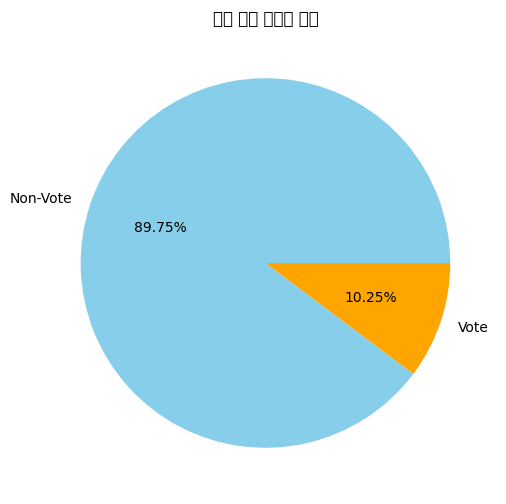

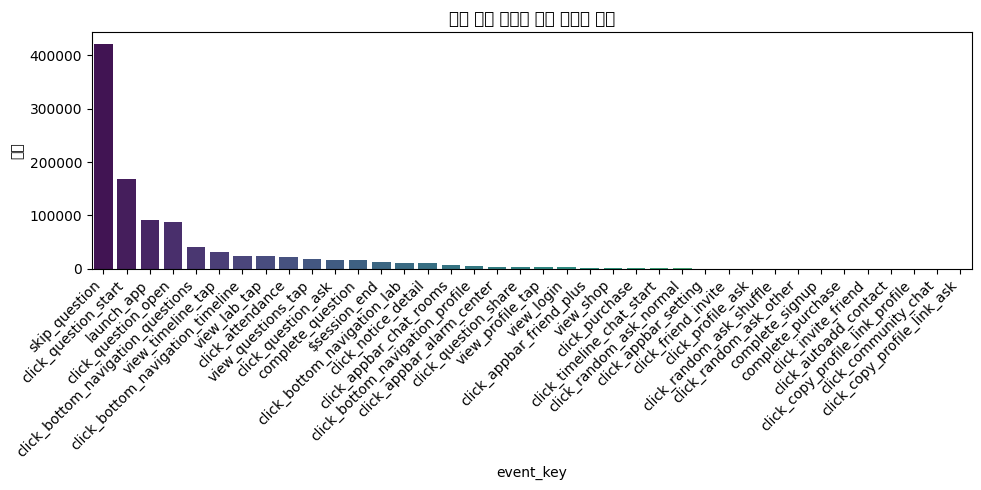

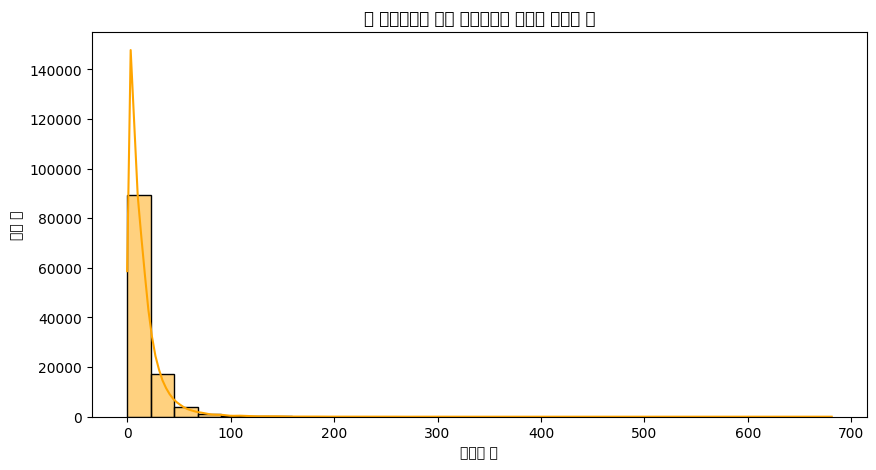

평균 이벤트 수: 15.40
최소 이벤트 수: 0
최대 이벤트 수: 681


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 투표 관련 이벤트 정의
vote_events = [
    'click_question_ask',
    'click_question_start',
    'complete_question',
    'click_question_share',
    'skip_question'
]

# 1. 전체 이벤트 분포에서 투표 관련 이벤트 비율 시각화
def plot_vote_event_distribution(df):
    df['is_vote_event'] = df['event_key'].isin(vote_events)
    vote_counts = df['is_vote_event'].value_counts()
    
    plt.figure(figsize=(6, 6))
    plt.pie(vote_counts, labels=['Non-Vote', 'Vote'], autopct='%.2f%%', colors=['skyblue', 'orange'])
    plt.title("투표 관련 이벤트 비율")
    plt.show()

# 2. 투표 관련 이벤트 직전 이벤트 분포
def plot_previous_event_distribution(df):
    df_sorted = df.sort_values(['session_id', 'event_datetime'])
    df_sorted['next_event'] = df_sorted['event_key'].shift(-1)
    
    prev_event_df = df_sorted[df_sorted['next_event'].isin(vote_events)]
    prev_counts = prev_event_df['event_key'].value_counts().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=prev_counts.index, y=prev_counts.values, palette='viridis')
    plt.title("투표 관련 이벤트 직전 이벤트 분포")
    plt.ylabel("횟수")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 3. 세션 내 첫 이벤트부터 투표 이벤트까지의 거리
def compute_min_steps_to_vote(df):
    df_sorted = df.sort_values(['session_id', 'event_datetime'])

    steps_to_vote = []

    for session_id, group in df_sorted.groupby('session_id'):
        group = group.reset_index(drop=True)

        try:
            vote_idx = group[group['event_key'].isin(vote_events)].index[0]
            steps_to_vote.append(vote_idx)  # 첫 이벤트 기준이므로 0부터 시작
        except IndexError:
            continue  # 투표 이벤트 없는 세션은 제외

    # 시각화
    plt.figure(figsize=(10, 5))
    sns.histplot(steps_to_vote, bins=30, kde=True, color='orange')
    plt.title("첫 이벤트부터 투표 이벤트까지 필요한 이벤트 수")
    plt.xlabel("이벤트 수")
    plt.ylabel("세션 수")
    plt.show()

    if steps_to_vote:
        print(f"평균 이벤트 수: {sum(steps_to_vote) / len(steps_to_vote):.2f}")
        print(f"최소 이벤트 수: {min(steps_to_vote)}")
        print(f"최대 이벤트 수: {max(steps_to_vote)}")
    else:
        print("투표 이벤트를 포함한 세션이 없습니다.")

# 실행
df['event_datetime'] = pd.to_datetime(df['event_datetime'])

plot_vote_event_distribution(df)
plot_previous_event_distribution(df)
compute_min_steps_to_vote(df)


In [ ]:
from collections import Counter
import pandas as pd
import plotly.express as px

# 날짜 타입 정리 및 정렬
df['event_datetime'] = pd.to_datetime(df['event_datetime'])
df_sorted = df.sort_values(by=['session_id', 'event_datetime'])

# launch_app 이후 흐름 경로 수집
paths = []
for session_id, group in df_sorted.groupby('session_id'):
    events = group['event_key'].tolist()
    for i in range(len(events) - 1):
        if events[i] == 'launch_app':
            path = [events[i]]
            for j in range(i + 1, min(i + 5, len(events))):  # 최대 5단계
                if events[j] == 'launch_app':  # 중복 제거
                    continue
                path.append(events[j])
            if len(path) >= 2:
                paths.append(" → ".join(path))
            break  # launch_app 이후 흐름 하나만 수집

# 경로 개수 세기
path_counts = Counter(paths)

print("📊 launch_app 이후 전환 경로 (상위 200개까지):\n")
for i, (path, count) in enumerate(path_counts.most_common()):
    if i >= 200:  # 너무 많으면 폭주 방지
        print(f"... (이 외에도 {len(path_counts) - 200}개 경로 더 있음)")
        break
    print(f"{i+1:>3}. {path} → {count}회")

📊 launch_app 이후 전환 경로 (상위 200개까지):

  1. launch_app → $session_start → $session_end → $session_start → 13063회
  2. launch_app → $session_start → 6765회
  3. launch_app → $session_end → $session_start → $session_start → 5934회
  4. launch_app → $session_end → $session_start → 4317회
  5. launch_app → $session_start → $session_end → $session_start → click_bottom_navigation_questions → 4307회
  6. launch_app → $session_end → $session_start → $session_start → click_bottom_navigation_questions → 3723회
  7. launch_app → $session_start → $session_start → 3238회
  8. launch_app → $session_end → $session_start → $session_end → 2735회
  9. launch_app → $session_start → view_login → $session_end → $session_start → 2620회
 10. launch_app → $session_start → $session_end → $session_start → click_appbar_alarm_center → 2606회
 11. launch_app → $session_end → $session_start → $session_start → click_appbar_alarm_center → 2182회
 12. launch_app → $session_start → $session_end → $session_start → view_timeline_tap 

In [ ]:
# 상위 5~10개의 흐름만 퍼널 시각화
for path, count in path_counts.most_common(5):  # 원하는 개수 조절
    steps = path.split(" → ")
    
    funnel_counts = []
    for i in range(1, len(steps) + 1):
        step_sequence = steps[:i]
        step_count = 0
        for session_id, group in df_sorted.groupby('session_id'):
            events = group['event_key'].tolist()
            for j in range(len(events) - len(step_sequence) + 1):
                if events[j:j + len(step_sequence)] == step_sequence:
                    step_count += 1
                    break
        funnel_counts.append((step_sequence[-1], step_count))

    funnel_df = pd.DataFrame(funnel_counts, columns=["Step", "UserCount"])
    fig = px.funnel(funnel_df, x="UserCount", y="Step", title=f"🔍 퍼널: {path}")
    fig.show()
